# INTRODUCTION
This notebook combines and explores daily flight data from Dallas Fort Worth (DFW) airport and daily weather data for DFW from Jan 1 2018 to Nov 17, 2023. The purpose is to produce models that can predict daily flight traffic, such as the number of total, ontime, cancelled, and delayed flights at Dallas Fort Worth Airport (DFW) from historical flight and weather data. This analysis is exploratory, but could be valuable to DFW airport management.

The daily weather data were obtained from a friend, Monte Lunacek, at the National Renewable Energy Laboratory (NREL) who obtained the data from the National Oceanic and Atmospheric Administration (NOAA), High-Resolution Rapid Refresh (HRRR) Data Archive: AWS OPen Data Program. The weather flight data was scaped from the Bureau of Transporation Statistics using Selenium.. 

In addition to merging the daily flight and weather data, this notebook engineers many features potentially relevant to flight traffic, such as time, date, and holiday features, and lag columns for total flights and cancelled flights. Column lists are created for convenient handling of features and targets. The final dataset is saved as "datav3/daily/daily_flights_and_weather_merged.parquet" for use in machine learning peformed in other notebooks.



## Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import datetime as dt

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.decomposition import PCA

DAILY_DATA_PATH = "data.v3/daily" 

pd.set_option("display.width", 600)

# DAILY FLIGHT DATA

In [2]:
flights_d = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights.parquet"))
print(f"Daily flights columns: {flights_d.columns.tolist()}")
print('Daily flights import shape:', flights_d.shape)

Daily flights columns: ['flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime']
Daily flights import shape: (2147, 21)


## Explore daily flights data

In [3]:
flights_d.describe().round().T

count    mean    std   min     25%     50%     75%     max
flights_cancel      2147.0    40.0  108.0   0.0     4.0    10.0    26.0  1330.0
flights_delay       2147.0   315.0  191.0   0.0   184.0   272.0   404.0  1270.0
flights_ontime      2147.0  1326.0  276.0  33.0  1228.0  1392.0  1508.0  1848.0
flights_arr         2147.0   840.0  138.0  17.0   795.0   867.0   932.0  1106.0
flights_dep         2147.0   841.0  138.0  16.0   792.0   869.0   934.0  1080.0
flights_arr_A       2147.0   154.0   27.0   0.0   143.0   159.0   173.0   227.0
flights_arr_B       2147.0   225.0   38.0   0.0   203.0   228.0   255.0   311.0
flights_arr_C       2147.0   172.0   40.0   0.0   149.0   182.0   202.0   244.0
flights_arr_D       2147.0   108.0   24.0  16.0    93.0   106.0   127.0   169.0
flights_arr_E       2147.0   181.0   48.0   1.0   142.0   185.0   221.0   280.0
flights_dep_A       2147.0   155.0   27.0   0.0   145.0   160.0   174.0   211.0
flights_dep_B       2147.0   224.0   38.0   0.0   203.0   227.0   255.0   319.0
flights_dep_C       2147.0   172.0   39.0   0.0   150.0   182.0   202.0   241.0
flights_dep_D       2147.0   105.0   24.0  16.0    89.0   102.0   124.0   166.0
flights_dep_E       2147.0   184.0   47.0   0.0   146.0   190.0   224.0   271.0
flights_arr_cancel  2147.0    21.0   54.0   0.0     2.0     6.0    14.0   643.0
flights_arr_delay   2147.0   148.0   96.0   0.0    84.0   125.0   186.0   651.0
flights_arr_ontime  2147.0   672.0  145.0  17.0   611.0   706.0   771.0   943.0
flights_dep_cancel  2147.0    19.0   55.0   0.0     1.0     4.0    12.0   687.0
flights_dep_delay   2147.0   167.0   99.0   0.0    99.0   148.0   217.0   649.0
flights_dep_ontime  2147.0   655.0  134.0  16.0   612.0   685.0   741.0   905.0

In [4]:
flights_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2147 entries, 2018-01-01 to 2023-11-17
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   flights_cancel      2147 non-null   float64
 1   flights_delay       2147 non-null   float64
 2   flights_ontime      2147 non-null   float64
 3   flights_arr         2147 non-null   float64
 4   flights_dep         2147 non-null   float64
 5   flights_arr_A       2147 non-null   float64
 6   flights_arr_B       2147 non-null   float64
 7   flights_arr_C       2147 non-null   float64
 8   flights_arr_D       2147 non-null   float64
 9   flights_arr_E       2147 non-null   float64
 10  flights_dep_A       2147 non-null   float64
 11  flights_dep_B       2147 non-null   float64
 12  flights_dep_C       2147 non-null   float64
 13  flights_dep_D       2147 non-null   float64
 14  flights_dep_E       2147 non-null   float64
 15  flights_arr_cancel  2147 non-null   f

In [5]:
flights_d.head().T

timestamp           2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05
flights_cancel           115.0        76.0        38.0        82.0        44.0
flights_delay            602.0       649.0       338.0       215.0       231.0
flights_ontime           985.0      1076.0      1349.0      1409.0      1439.0
flights_arr              870.0       884.0       863.0       851.0       857.0
flights_dep              832.0       917.0       862.0       855.0       857.0
flights_arr_A            177.0       178.0       177.0       165.0       172.0
flights_arr_B            298.0       279.0       276.0       282.0       283.0
flights_arr_C            187.0       190.0       193.0       192.0       192.0
flights_arr_D            100.0       110.0        94.0        91.0        93.0
flights_arr_E            108.0       127.0       123.0       121.0       117.0
flights_dep_A            168.0       185.0       175.0       173.0       174.0
flights_dep_B            275.0       301.0       282.0       283.0       282.0
flights_dep_C            180.0       201.0       192.0       183.0       193.0
flights_dep_D             99.0       102.0        91.0        94.0        92.0
flights_dep_E            110.0       128.0       122.0       122.0       116.0
flights_arr_cancel        70.0        36.0        18.0        39.0        23.0
flights_arr_delay        264.0       276.0       142.0       104.0        94.0
flights_arr_ontime       536.0       572.0       703.0       708.0       740.0
flights_dep_cancel        45.0        40.0        20.0        43.0        21.0
flights_dep_delay        338.0       373.0       196.0       111.0       137.0
flights_dep_ontime       449.0       504.0       646.0       701.0       699.0

In [6]:
flights_d.tail().T

timestamp           2023-11-13  2023-11-14  2023-11-15  2023-11-16  2023-11-17
flights_cancel             6.0         1.0         6.0         0.0         0.0
flights_delay            214.0        53.0         0.0         0.0         0.0
flights_ontime          1672.0      1767.0      1623.0        65.0        33.0
flights_arr              945.0       910.0       810.0        41.0        17.0
flights_dep              947.0       911.0       819.0        24.0        16.0
flights_arr_A            161.0       161.0       161.0         7.0         0.0
flights_arr_B            249.0       237.0       225.0         0.0         0.0
flights_arr_C            210.0       210.0       191.0         2.0         0.0
flights_arr_D            134.0       125.0       141.0        25.0        16.0
flights_arr_E            191.0       177.0        92.0         7.0         1.0
flights_dep_A            166.0       161.0       162.0         0.0         0.0
flights_dep_B            246.0       236.0       225.0         0.0         0.0
flights_dep_C            213.0       209.0       193.0         0.0         0.0
flights_dep_D            132.0       130.0       136.0        17.0        16.0
flights_dep_E            190.0       175.0       103.0         7.0         0.0
flights_arr_cancel         3.0         0.0         2.0         0.0         0.0
flights_arr_delay         93.0        25.0         0.0         0.0         0.0
flights_arr_ontime       849.0       885.0       808.0        41.0        17.0
flights_dep_cancel         3.0         1.0         4.0         0.0         0.0
flights_dep_delay        121.0        28.0         0.0         0.0         0.0
flights_dep_ontime       823.0       882.0       815.0        24.0        16.0

### Missing values in daily flight data

In [7]:
flights_d['date'] = flights_d.index
flights_d['year'] = flights_d['date'].dt.year
missing = flights_d.groupby('year').apply(lambda x: x.isnull().sum())
print("Missing values per year:", missing)

Missing values per year:       flights_cancel  flights_delay  flights_ontime  flights_arr  flights_dep  flights_arr_A  flights_arr_B  flights_arr_C  flights_arr_D  flights_arr_E  ...  flights_dep_D  flights_dep_E  flights_arr_cancel  flights_arr_delay  flights_arr_ontime  flights_dep_cancel  flights_dep_delay  flights_dep_ontime  date  year
year                                                                                                                                                      ...                                                                                                                                                                
2018               0              0               0            0            0              0              0              0              0              0  ...              0              0                   0                  0                   0                   0                  0                   0     0     0
2019               0 

/var/folders/l7/c4mdhp113ds3zk1sw7x0mjtccxhkjp/T/ipykernel_67674/938010236.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing = flights_d.groupby('year').apply(lambda x: x.isnull().sum())


# DAILY WEATHER
Source: NOAA Global Systems Laboratory, High-Resolution Rapid Refresh (HRRR) Data Archive: AWS OPen Data Program\
Data dictionary: [HRRR Zarr Variable List](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html)

In [8]:
weather_d = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_weather.parquet"))
print(f"Weather columns: {weather_d.columns.tolist()}")
print("Daily weather import shape:", weather_d.shape)

Weather columns: ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']
Daily weather import shape: (4809, 13)


## Explore daily weather

In [9]:
weather_d.describe().round().T

count   mean     std   min    25%    50%     75%     max
wx_temperature_max  1692.0   86.0    21.0  21.0   70.0   86.0   103.0   129.0
wx_temperature_min  1692.0   57.0    17.0  -6.0   43.0   58.0    73.0    86.0
wx_apcp             1692.0    0.0     1.0   0.0    0.0    0.0     0.0     6.0
wx_prate            1692.0    0.0     0.0   0.0    0.0    0.0     0.0     3.0
wx_asnow            1692.0    0.0     0.0   0.0    0.0    0.0     0.0     6.0
wx_frozr            1692.0    0.0     0.0   0.0    0.0    0.0     0.0     1.0
wx_vis              1692.0   10.0     6.0   0.0    8.0    9.0    13.0    41.0
wx_gust             1692.0   26.0     9.0   7.0   19.0   25.0    31.0    61.0
wx_maxref           1692.0   10.0    17.0   0.0    0.0    0.0    20.0    60.0
wx_cape             1692.0  961.0  1157.0   0.0    0.0  310.0  1830.0  5580.0
wx_lftx             1692.0    1.0     9.0 -14.0   -6.0   -2.0     8.0    35.0
wx_wind_speed       1692.0    8.0     3.0   3.0    6.0    8.0    10.0    22.0
wx_wind_direction   1692.0  174.0    62.0   9.0  141.0  177.0   203.0   344.0

In [10]:
weather_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4809 entries, 2010-01-01 to NaT
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wx_temperature_max  1692 non-null   float64
 1   wx_temperature_min  1692 non-null   float64
 2   wx_apcp             1692 non-null   float64
 3   wx_prate            1692 non-null   float64
 4   wx_asnow            1692 non-null   float64
 5   wx_frozr            1692 non-null   float64
 6   wx_vis              1692 non-null   float64
 7   wx_gust             1692 non-null   float64
 8   wx_maxref           1692 non-null   float32
 9   wx_cape             1692 non-null   float32
 10  wx_lftx             1692 non-null   float32
 11  wx_wind_speed       1692 non-null   float64
 12  wx_wind_direction   1692 non-null   float32
dtypes: float32(4), float64(9)
memory usage: 450.8 KB


In [11]:
weather_d.head().T

2010-01-01  2010-01-02  2010-01-03  2010-01-04  2010-01-05
wx_temperature_max         NaN         NaN         NaN         NaN         NaN
wx_temperature_min         NaN         NaN         NaN         NaN         NaN
wx_apcp                    NaN         NaN         NaN         NaN         NaN
wx_prate                   NaN         NaN         NaN         NaN         NaN
wx_asnow                   NaN         NaN         NaN         NaN         NaN
wx_frozr                   NaN         NaN         NaN         NaN         NaN
wx_vis                     NaN         NaN         NaN         NaN         NaN
wx_gust                    NaN         NaN         NaN         NaN         NaN
wx_maxref                  NaN         NaN         NaN         NaN         NaN
wx_cape                    NaN         NaN         NaN         NaN         NaN
wx_lftx                    NaN         NaN         NaN         NaN         NaN
wx_wind_speed              NaN         NaN         NaN         NaN         NaN
wx_wind_direction          NaN         NaN         NaN         NaN         NaN

In [12]:
weather_d.tail().T

2023-02-26  2023-02-27  2023-02-28   2023-03-01  NaT
wx_temperature_max   70.112177   80.246021   91.236523    86.436652  NaN
wx_temperature_min   44.515405   43.433032   44.967657    56.921002  NaN
wx_apcp               0.058400    0.193600    0.030600     0.638400  NaN
wx_prate              0.000000    0.014173    0.000000     0.113386  NaN
wx_asnow              0.000000    0.000000    0.000000     0.000000  NaN
wx_frozr              0.000000    0.000000    0.000000     0.000000  NaN
wx_vis                7.580729    8.699197   19.635330     2.609759  NaN
wx_gust              46.485129   44.398234   24.038371    21.738880  NaN
wx_maxref            26.437500   44.937500    0.000000    51.562500  NaN
wx_cape             770.000000  120.000000    0.000000  2110.000000  NaN
wx_lftx              -3.400000    1.700000   10.500000    -7.000000  NaN
wx_wind_speed         9.476811    9.624294    6.849457     6.756946  NaN
wx_wind_direction   173.093796  239.058182  209.854950   187.290634  NaN

## Missing values in daily weather

In [13]:
# count the missing values in each column aggregated by year
weather_d['date'] = weather_d.index
weather_d['year'] = weather_d['date'].dt.year
missing = weather_d.groupby('year').apply(lambda x: x.isnull().sum())
print("Missing values by year and variable\n", missing.T)

# Show rows where the year is 2022 and there are missing values in the weather data
print("\nAnomalous missing values on October 1st, 2022\n")
print(weather_d[(weather_d['year'] == 2022) & (weather_d.isnull().any(axis=1))])

Missing values by year and variable
 year                2010.0  2011.0  2012.0  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  2021.0  2022.0  2023.0
wx_temperature_max     365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_temperature_min     365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_apcp                365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_prate               365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_asnow               365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_frozr               365     365     366     365     365     365     366     365     193       0       0       0       1       0
wx_vis                 365     365     366    

/var/folders/l7/c4mdhp113ds3zk1sw7x0mjtccxhkjp/T/ipykernel_67674/1147223249.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing = weather_d.groupby('year').apply(lambda x: x.isnull().sum())


## Drop years and rows with no weather data

In [14]:
weather_d_incomplete = weather_d[weather_d.isnull().any(axis=1)]
weather_d_complete = weather_d[~(weather_d.isnull().any(axis=1))]

print("Number of weather rows with missing values:", weather_d_incomplete.shape[0])
print("\nDaily weather final shape:", weather_d_complete.shape)

Number of weather rows with missing values: 3117

Daily weather final shape: (1692, 15)


In [15]:
weather_d_complete.head().T

2018-07-13           2018-07-14           2018-07-15           2018-07-16           2018-07-17
wx_temperature_max            114.65921            116.12171             119.0466           119.834155           123.884155
wx_temperature_min            86.081519            75.439008            80.635596            81.717804            82.303101
wx_apcp                          0.0104               0.3344               0.0004                0.006                0.006
wx_prate                            0.0             0.113386                  0.0                  0.0                  0.0
wx_asnow                            0.0                  0.0                  0.0                  0.0                  0.0
wx_frozr                            0.0                  0.0                  0.0                  0.0                  0.0
wx_vis                        19.883879             4.846695            13.110933            15.037183            19.262508
wx_gust                        23.09549            22.704622            23.629119            23.478253            24.599262
wx_maxref                           0.0              30.3125                  0.0                  0.0                  0.0
wx_cape                          2110.0               1920.0               1940.0               1810.0                830.0
wx_lftx                            -5.1                 -4.8                 -5.6                 -5.7                 -3.4
wx_wind_speed                  9.254536               7.2707             8.194324             7.721187             7.713826
wx_wind_direction            164.564392           174.650345           198.971619           198.751419           225.905609
date                2018-07-13 00:00:00  2018-07-14 00:00:00  2018-07-15 00:00:00  2018-07-16 00:00:00  2018-07-17 00:00:00
year                             2018.0               2018.0               2018.0               2018.0               2018.0

In [16]:
weather_d_complete.tail().T

2023-02-25           2023-02-26           2023-02-27           2023-02-28           2023-03-01
wx_temperature_max            48.024988            70.112177            80.246021            91.236523            86.436652
wx_temperature_min            39.254712            44.515405            43.433032            44.967657            56.921002
wx_apcp                           0.184               0.0584               0.1936               0.0306               0.6384
wx_prate                       0.056693                  0.0             0.014173                  0.0             0.113386
wx_asnow                            0.0                  0.0                  0.0                  0.0                  0.0
wx_frozr                            0.0                  0.0                  0.0                  0.0                  0.0
wx_vis                         3.728227             7.580729             8.699197             19.63533             2.609759
wx_gust                       14.698074            46.485129            44.398234            24.038371             21.73888
wx_maxref                         31.75              26.4375              44.9375                  0.0              51.5625
wx_cape                             0.0                770.0                120.0                  0.0               2110.0
wx_lftx                            19.4                 -3.4                  1.7                 10.5                 -7.0
wx_wind_speed                  4.978028             9.476811             9.624294             6.849457             6.756946
wx_wind_direction            161.247086           173.093796           239.058182            209.85495           187.290634
date                2023-02-25 00:00:00  2023-02-26 00:00:00  2023-02-27 00:00:00  2023-02-28 00:00:00  2023-03-01 00:00:00
year                             2023.0               2023.0               2023.0               2023.0               2023.0

# MERGE FLIGHT AND WEATHER DATA
Note: The weather data covers a shorter time period than the flights data. Can we get more weather data?

In [17]:
# Merge flights and weather data
df = pd.merge(flights_d.drop(['year', 'date'], axis=1), 
              weather_d_complete.drop(['year', 'date'], axis=1), 
              left_index=True, right_index=True, how='inner')

print("flights_d shape:", flights_d.shape)
print("weather_d_complete shape:", weather_d_complete.shape)
print("merged shape:", df.shape)
print('\nHEAD\n', df.head(2).T)
print('\nTAIL\n', df.tail(2).T)


flights_d shape: (2147, 23)
weather_d_complete shape: (1692, 15)
merged shape: (1692, 34)

HEAD
                      2018-07-13   2018-07-14
flights_cancel        48.000000    12.000000
flights_delay        481.000000   320.000000
flights_ontime      1382.000000  1431.000000
flights_arr          949.000000   881.000000
flights_dep          962.000000   882.000000
flights_arr_A        194.000000   181.000000
flights_arr_B        262.000000   254.000000
flights_arr_C        221.000000   210.000000
flights_arr_D        111.000000   107.000000
flights_arr_E        161.000000   129.000000
flights_dep_A        205.000000   187.000000
flights_dep_B        265.000000   255.000000
flights_dep_C        222.000000   207.000000
flights_dep_D        104.000000    98.000000
flights_dep_E        166.000000   135.000000
flights_arr_cancel    38.000000     9.000000
flights_arr_delay    202.000000   135.000000
flights_arr_ontime   709.000000   737.000000
flights_dep_cancel    10.000000     3.000000
fli

# FEATURE ENGINEERING

## Add time, date, and holiday features

In [18]:
import datetime as dt
from dateutil.easter import easter

# create a date column from index
df['date'] = df.index
df['year'] = df['date'].dt.year
# df['year_c'] = df['date'].dt.year.astype('category')
df['month'] = df['date'].dt.strftime('%B')
df['day_of_week'] = df['date'].dt.strftime('%A')
df['day_of_month'] = df['date'].dt.day

# Create an ordinal date column (days since 1/1/1)
df['ordinal_date'] = df['date'].map(dt.datetime.toordinal)

# add season column
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['season'] = df['date'].apply(get_season)

# Holidays
years = range(df['year'].min(), df['year'].max()+1)
us_holidays = holidays.US(years = years)

# Reverse dictionaries of US Holidays spanning the years in the dataset
# for year in years:
#     globals()[f"holidays_{year}"] = {v: k for k, v in holidays.US(years=year).items()}

# add holiday column
def check_holiday(date):
    # us_holidays = holidays.US(years = date.year)
    return us_holidays.get(date, "Not a Holiday")
df['holiday'] = df['date'].apply(check_holiday)

# add "halloween" column
def halloween(date):
    if date.month == 10 and date.day == 31:
        return 'yes'
    else:
        return 'no'
df['halloween'] = df['date'].apply(halloween)

# add "jan_2" column
def jan_2(date):
    if date.month == 1 and date.day == 2:
        return 'yes'
    else:
        return 'no'
df['jan_2'] = df['date'].apply(jan_2)
    
# add "jan_3" column
def jan_3(date):
    if date.month == 1 and date.day == 3:
        return 'yes'
    else:
        return 'no'
df['jan_3'] = df['date'].apply(jan_3)
    

# add column for the day before easter
def day_before_easter(date):
    normalized_input_date = date.date()
    day_before_easter_date = easter(date.year) - dt.timedelta(days=1)
    if normalized_input_date == day_before_easter_date:
        return 'yes'
    else:
        return 'no'
df['day_before_easter'] = df['date'].apply(day_before_easter)

# add column for the Xmas Eve
def xmas_eve(date):
    if date.month == 12 and date.day == 24:
        return 'yes'
    else:
        return 'no'
df['xmas_eve'] = df['date'].apply(xmas_eve)

# add column for New Year's eve
def new_years_eve(date):
    if date.month == 12 and date.day == 31:
        return 'yes'
    else:
        return 'no'
df['new_years_eve'] = df['date'].apply(new_years_eve)

# add "days_until_Xmas" column
def days_until_xmas(date):
    xmas = pd.to_datetime(f"{date.year}-12-25")
    if date > xmas:
        xmas = pd.to_datetime(f"{date.year+1}-12-25")
    return (xmas - date).days
df['days_until_xmas'] = df['date'].apply(days_until_xmas)


# add "days_until_thanksgiving" column
def days_until_thanksgiving(date):
    # Thanksgiving is the 4th Thursday of November
    # https://www.timeanddate.com/holidays/us/thanksgiving-day
    thanksgiving = pd.to_datetime(f"{date.year}-11-01")
    while thanksgiving.weekday() != 3:
        thanksgiving += pd.Timedelta(days=1)
    thanksgiving += pd.Timedelta(days=21)
    return (thanksgiving - date).days
df['days_until_thanksgiving'] = df['date'].apply(days_until_thanksgiving)

# add "days_until_July_4th" column
def days_until_july_4th(date):
    july_4th = pd.to_datetime(f"{date.year}-07-04")
    if date > july_4th:
        july_4th = pd.to_datetime(f"{date.year+1}-07-04")
    return (july_4th - date).days
df['days_until_july_4th'] = df['date'].apply(days_until_july_4th)

# add "days_until_labor_day" column
def days_until_labor_day(date):
    # Labor Day is the first Monday of September
    labor_day = pd.to_datetime(f"{date.year}-09-01")
    while labor_day.weekday() != 0:
        labor_day += pd.Timedelta(days=1)
    return (labor_day - date).days
df['days_until_labor_day'] = df['date'].apply(days_until_labor_day)

# add "days_until_memorial_day" column
def days_until_memorial_day(date):
    # Memorial Day is the last Monday of May
    memorial_day = pd.to_datetime(f"{date.year}-05-01")
    if date > memorial_day:
        memorial_day = pd.to_datetime(f"{date.year+1}-05-01")
    return (memorial_day - date).days
df['days_until_memorial_day'] = df['date'].apply(days_until_memorial_day)

# add covid column. The WHO declared COVID-19 a pandemic on March 11, 2020. Record-breaking Thanksgiving travel in 2023 suggests a full recovery by 11/23/23.
mask = (df['date'] >= '2020-03-11') & (df['date'] <= '2023-11-23')
df['covid'] = np.where(mask, 'yes', 'no')

In [19]:
# reset index
# df.reset_index(drop=True, inplace=True)
print(df.columns.tolist())
print("Day before easter dates:", df[df['day_before_easter'] == 'yes']['date'].tolist())
df.head().T

['flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'date', 'year', 'month', 'day_of_week', 'day_of_month', 'ordinal_date', 'season', 'holiday', 'halloween', 'jan_2', 'jan_3', 'day_before_easter', 'xmas_eve', 'new_years_eve', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'covid']
Day before easter dates: [Timestamp('2019-04-20 00:00:00'), Timestamp('2020-04-11 00:00:00'), Timestamp('2021-04-03 00:00:00'), 

2018-07-13           2018-07-14           2018-07-15           2018-07-16           2018-07-17
flights_cancel                          48.0                 12.0                 14.0                 16.0                 24.0
flights_delay                          481.0                320.0                381.0                401.0                378.0
flights_ontime                        1382.0               1431.0               1466.0               1456.0               1475.0
flights_arr                            949.0                881.0                930.0                934.0                941.0
flights_dep                            962.0                882.0                931.0                939.0                936.0
flights_arr_A                          194.0                181.0                193.0                185.0                195.0
flights_arr_B                          262.0                254.0                267.0                270.0                266.0
flights_arr_C                          221.0                210.0                220.0                231.0                218.0
flights_arr_D                          111.0                107.0                 98.0                 91.0                102.0
flights_arr_E                          161.0                129.0                152.0                157.0                160.0
flights_dep_A                          205.0                187.0                194.0                188.0                196.0
flights_dep_B                          265.0                255.0                268.0                270.0                263.0
flights_dep_C                          222.0                207.0                226.0                232.0                217.0
flights_dep_D                          104.0                 98.0                 90.0                 87.0                 98.0
flights_dep_E                          166.0                135.0                153.0                162.0                162.0
flights_arr_cancel                      38.0                  9.0                 10.0                  9.0                 13.0
flights_arr_delay                      202.0                135.0                157.0                170.0                167.0
flights_arr_ontime                     709.0                737.0                763.0                755.0                761.0
flights_dep_cancel                      10.0                  3.0                  4.0                  7.0                 11.0
flights_dep_delay                      279.0                185.0                224.0                231.0                211.0
flights_dep_ontime                     673.0                694.0                703.0                701.0                714.0
wx_temperature_max                 114.65921            116.12171             119.0466           119.834155           123.884155
wx_temperature_min                 86.081519            75.439008            80.635596            81.717804            82.303101
wx_apcp                               0.0104               0.3344               0.0004                0.006                0.006
wx_prate                                 0.0             0.113386                  0.0                  0.0                  0.0
wx_asnow                                 0.0                  0.0                  0.0                  0.0                  0.0
wx_frozr                                 0.0                  0.0                  0.0                  0.0                  0.0
wx_vis                             19.883879             4.846695            13.110933            15.037183            19.262508
wx_gust                             23.09549            22.704622            23.629119            23.478253            24.599262
wx_maxref                                0.0              30.3125                  0.0                  0.0                  0.0
wx_cape                            

In [20]:
# Move date, holiday, COVID to front of dataframe
cols = df.columns.tolist()
date_cols= ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']
col_order = date_cols + [col for col in cols if col not in date_cols]
df = df[col_order]

print(df.head(2).T)

                                  2018-07-13           2018-07-14
date                     2018-07-13 00:00:00  2018-07-14 00:00:00
covid                                     no                   no
ordinal_date                          736888               736889
year                                    2018                 2018
month                                   July                 July
day_of_month                              13                   14
day_of_week                           Friday             Saturday
season                                summer               summer
holiday                        Not a Holiday        Not a Holiday
halloween                                 no                   no
xmas_eve                                  no                   no
new_years_eve                             no                   no
jan_2                                     no                   no
jan_3                                     no                   no
day_before

## Add flights total and percent delayed, ontime, cancelled columns

In [21]:
# Calculate percentages for total flights
df['flights_total'] = df['flights_cancel'] + df['flights_delay'] + df['flights_ontime']
df['flights_cancel_pct'] = 100*df['flights_cancel'] / df['flights_total']
df['flights_delay_pct'] = 100*df['flights_delay'] / df['flights_total']
df['flights_ontime_pct'] = 100*df['flights_ontime'] / df['flights_total']

# Calculate percentages for arrivals
df['flights_arr_delay_pct'] = 100*df['flights_arr_delay'] / df['flights_arr']
df['flights_arr_ontime_pct'] = 100*df['flights_arr_ontime'] / df['flights_arr']
df['flights_arr_cancel_pct'] = 100*df['flights_arr_cancel'] / df['flights_arr']

# Calculate percentages for departures
df['flights_dep_delay_pct'] = 100*df['flights_dep_delay'] / df['flights_dep']
df['flights_dep_ontime_pct'] = 100*df['flights_dep_ontime'] / df['flights_dep']
df['flights_dep_cancel_pct'] = 100*df['flights_dep_cancel'] / df['flights_dep']

print(df.head().T)

print('shape:', df.shape)

                                 2018-07-13           2018-07-14           2018-07-15           2018-07-16           2018-07-17
date                    2018-07-13 00:00:00  2018-07-14 00:00:00  2018-07-15 00:00:00  2018-07-16 00:00:00  2018-07-17 00:00:00
covid                                    no                   no                   no                   no                   no
ordinal_date                         736888               736889               736890               736891               736892
year                                   2018                 2018                 2018                 2018                 2018
month                                  July                 July                 July                 July                 July
...                                     ...                  ...                  ...                  ...                  ...
flights_arr_ontime_pct            74.710221            83.654938            82.043011            80.8351

## Add 7 lag features each for cancelled, delayed, and ontime flights using 1 day steps

In [22]:
df_lag = df.copy()


lag_cols = []

cols_to_lag = ['flights_cancel', 'flights_delay', 'flights_ontime']
for col in cols_to_lag:
    for lag in [1, 2, 3, 4, 5, 6, 7]:
        df_lag[f"{col}_lag_{lag}"] = df[col].shift(lag)
        lag_cols.append(f"{col}_lag_{lag}")

df_lag.dropna(inplace=True)

print(df_lag.shape)
print(f"Lag cols: {lag_cols}")
# print("\n", df_lag[['flights_total', 'flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3']].head().T)
print("\n", df_lag[['flights_cancel', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3']].head().T)
print("\n", df_lag[['flights_delay', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3']].head().T)
print("\n", df_lag[['flights_ontime', 'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3']].head().T)

(1685, 85)
Lag cols: ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7', 'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7']

                       2018-07-20  2018-07-21  2018-07-22  2018-07-23  2018-07-24
flights_cancel              24.0        30.0        18.0        48.0        14.0
flights_cancel_lag_1        25.0        24.0        30.0        18.0        48.0
flights_cancel_lag_2        16.0        25.0        24.0        30.0        18.0
flights_cancel_lag_3        24.0        16.0        25.0        24.0        30.0

                      2018-07-20  2018-07-21  2018-07-22  2018-07-23  201

## Add a random feature to test RFE

In [23]:
# Add a random variable to df_lag with repeatable results
np.random.seed(42)
df_lag['random'] = np.random.randint(0, 100, df_lag.shape[0])

## Column Groups (flights, weather, date)

In [24]:
# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7']

## Export data to parquet

In [25]:
# Export the final dataframe
df_lag.to_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# INTRODUCTION
This noteboook imports the merged and preprocessed data for daily flights and weather produced by "1. daily_import_merge_engineer.ipynb". Exploratory data analysis is performed in this notebook. 

## Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data & column groups

In [2]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# EXPLORATORY DATA ANALYSIS

## Total flights by day for each month

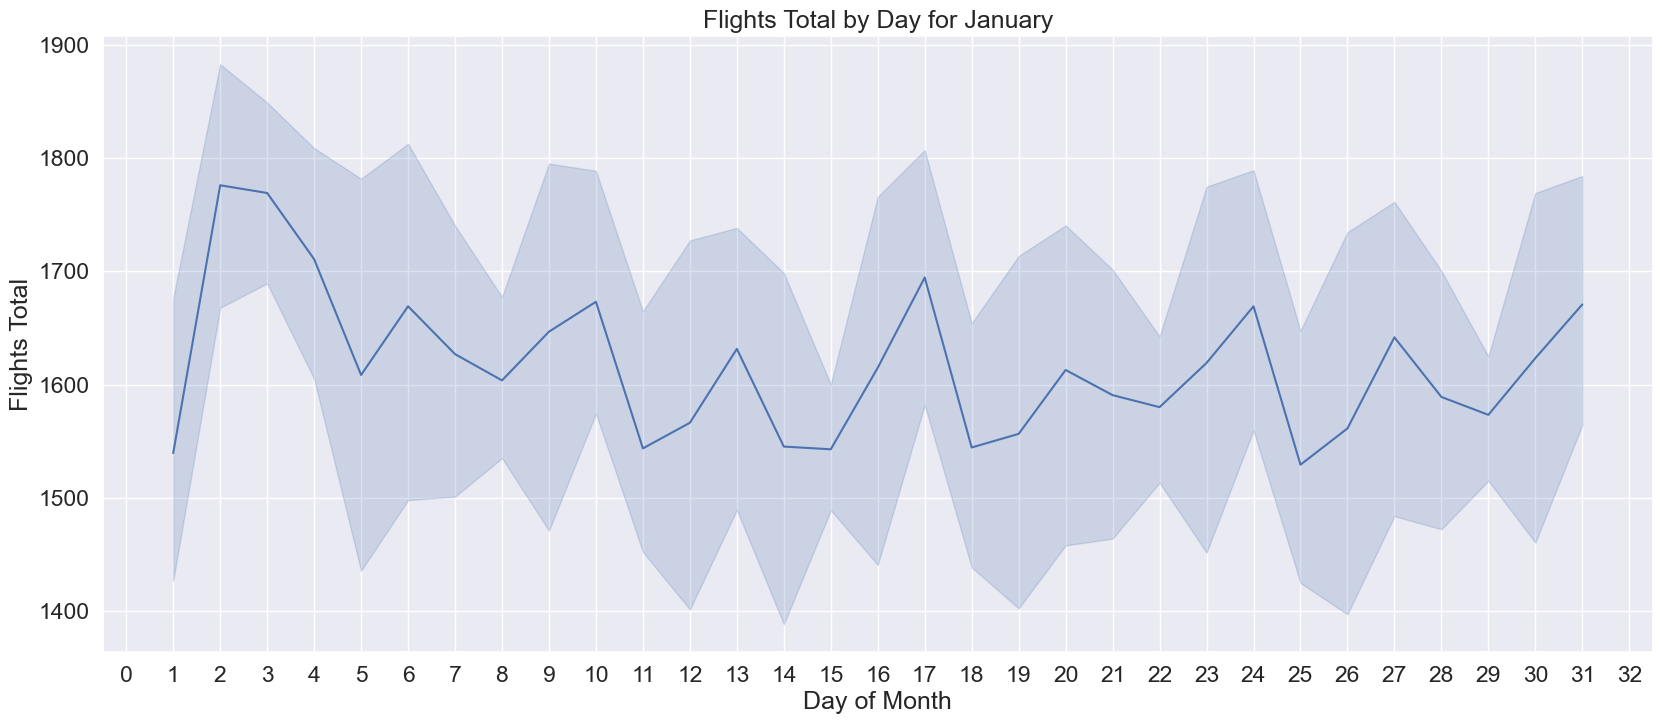

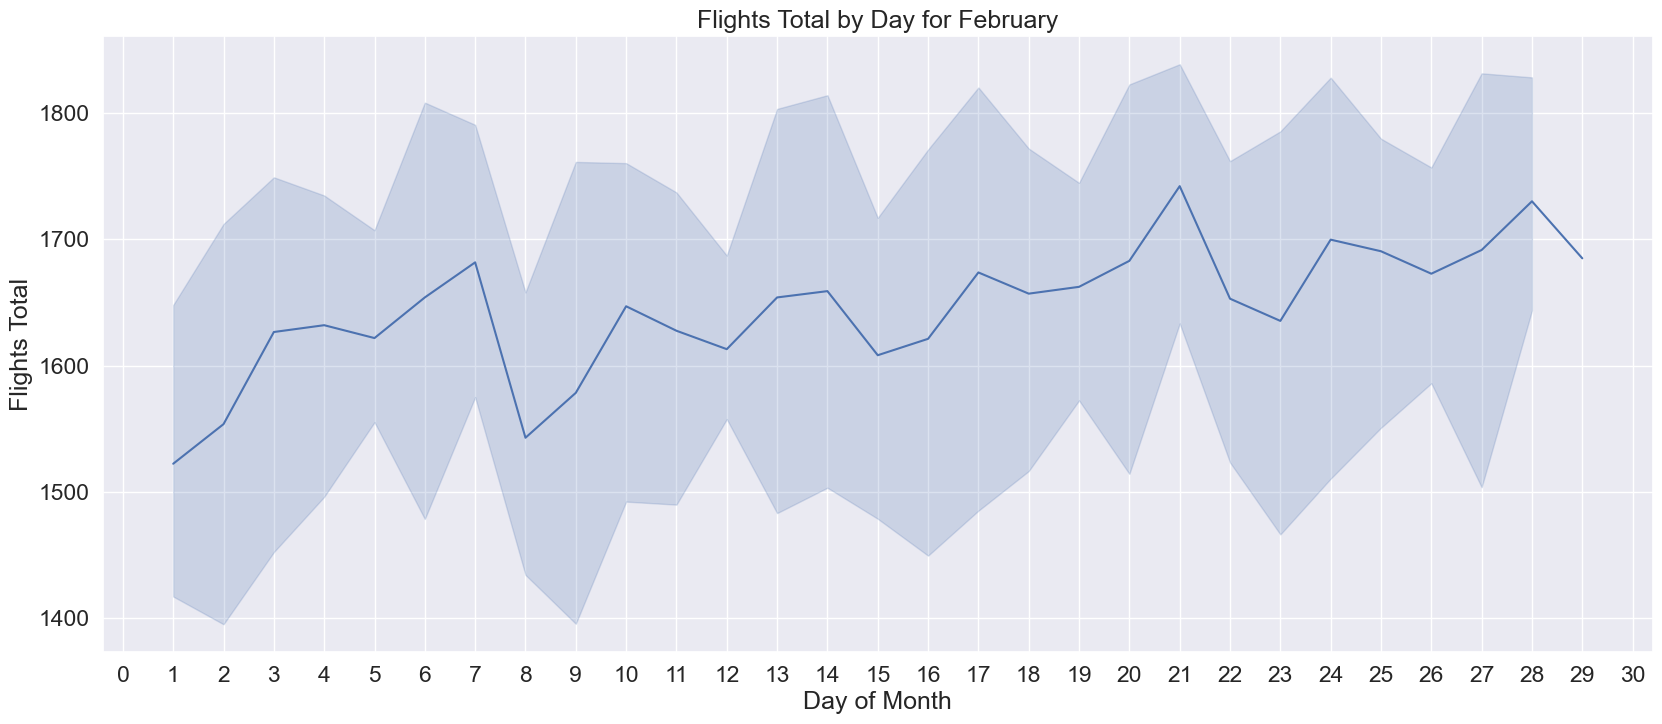

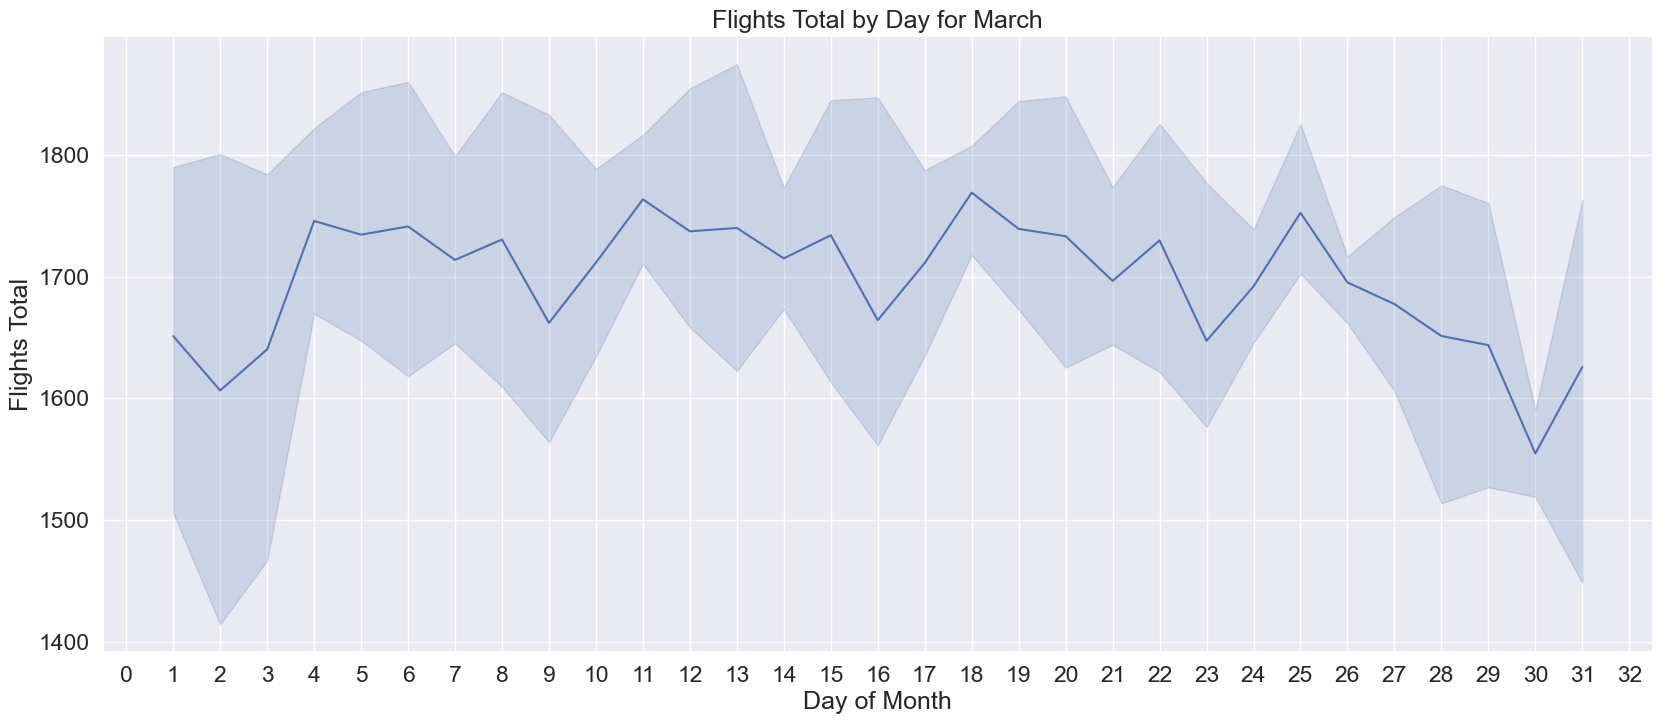

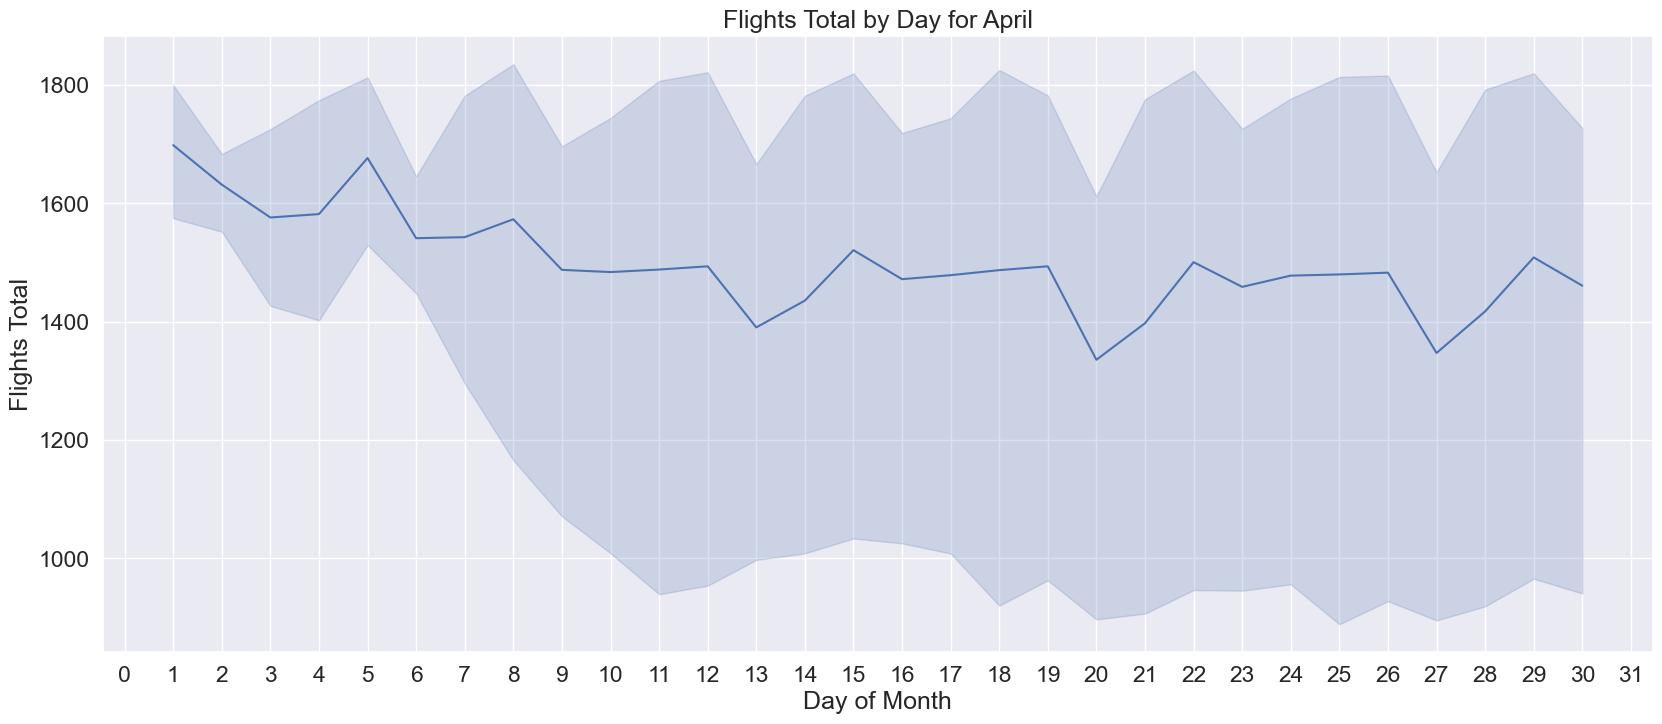

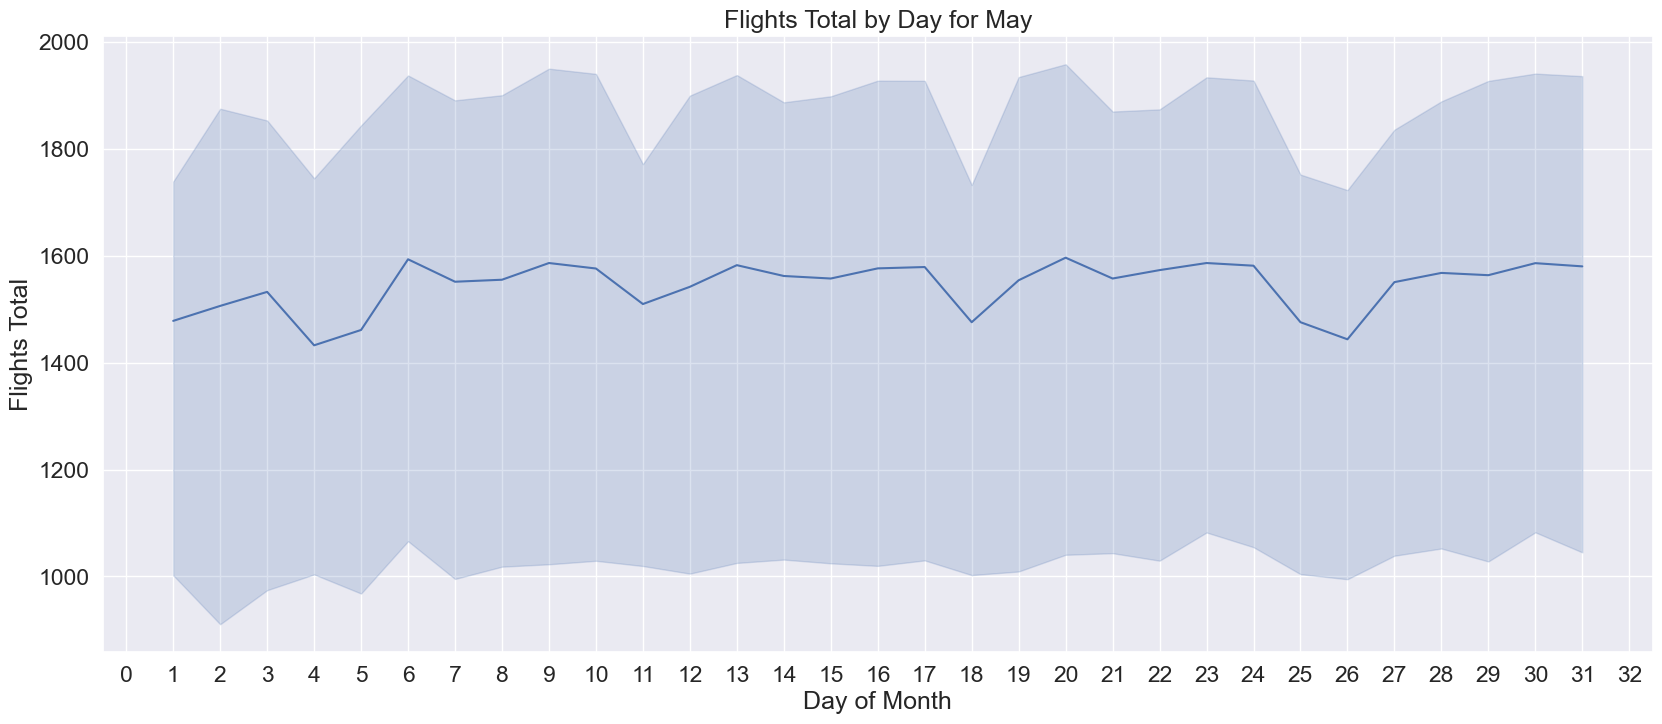

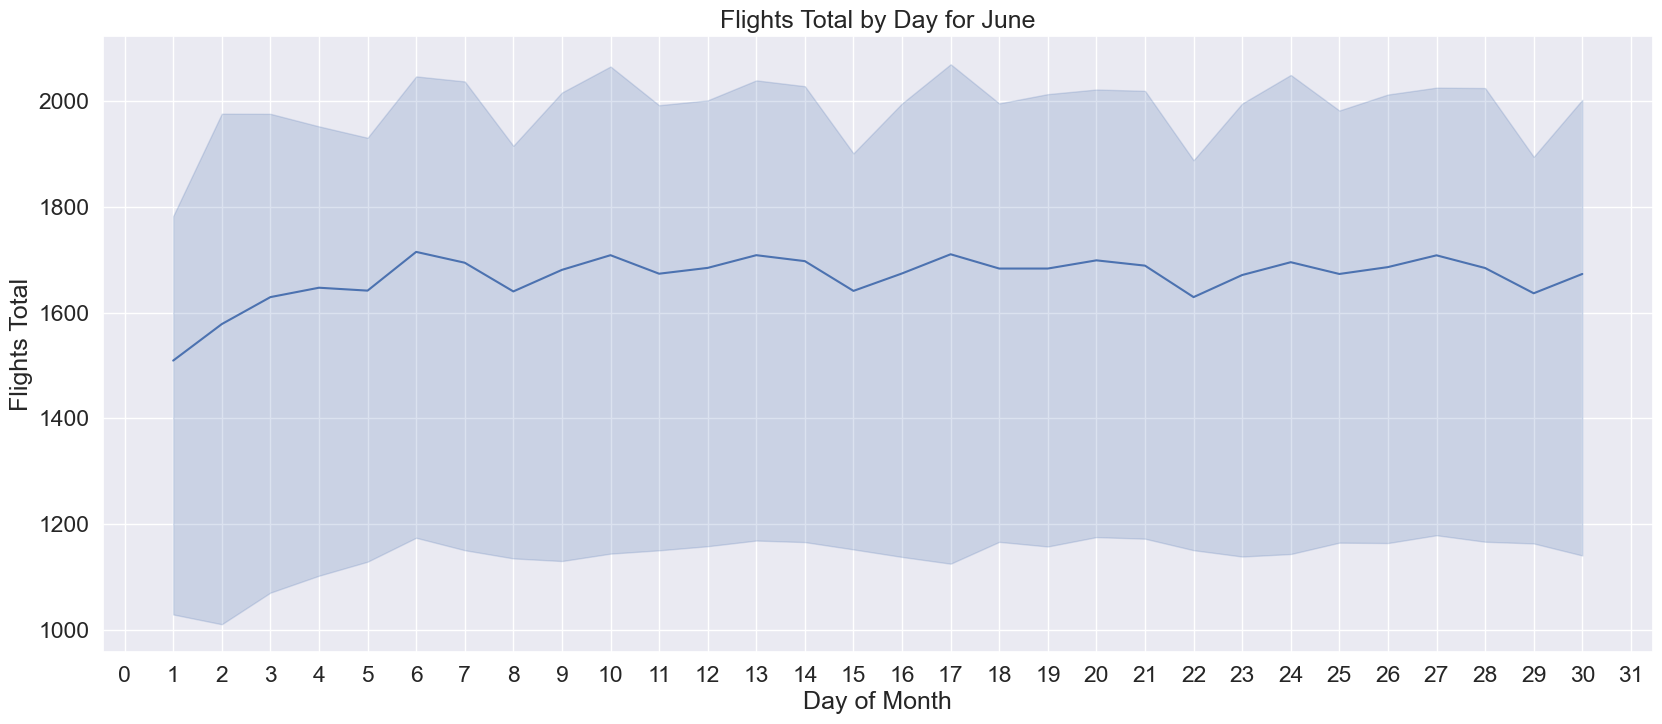

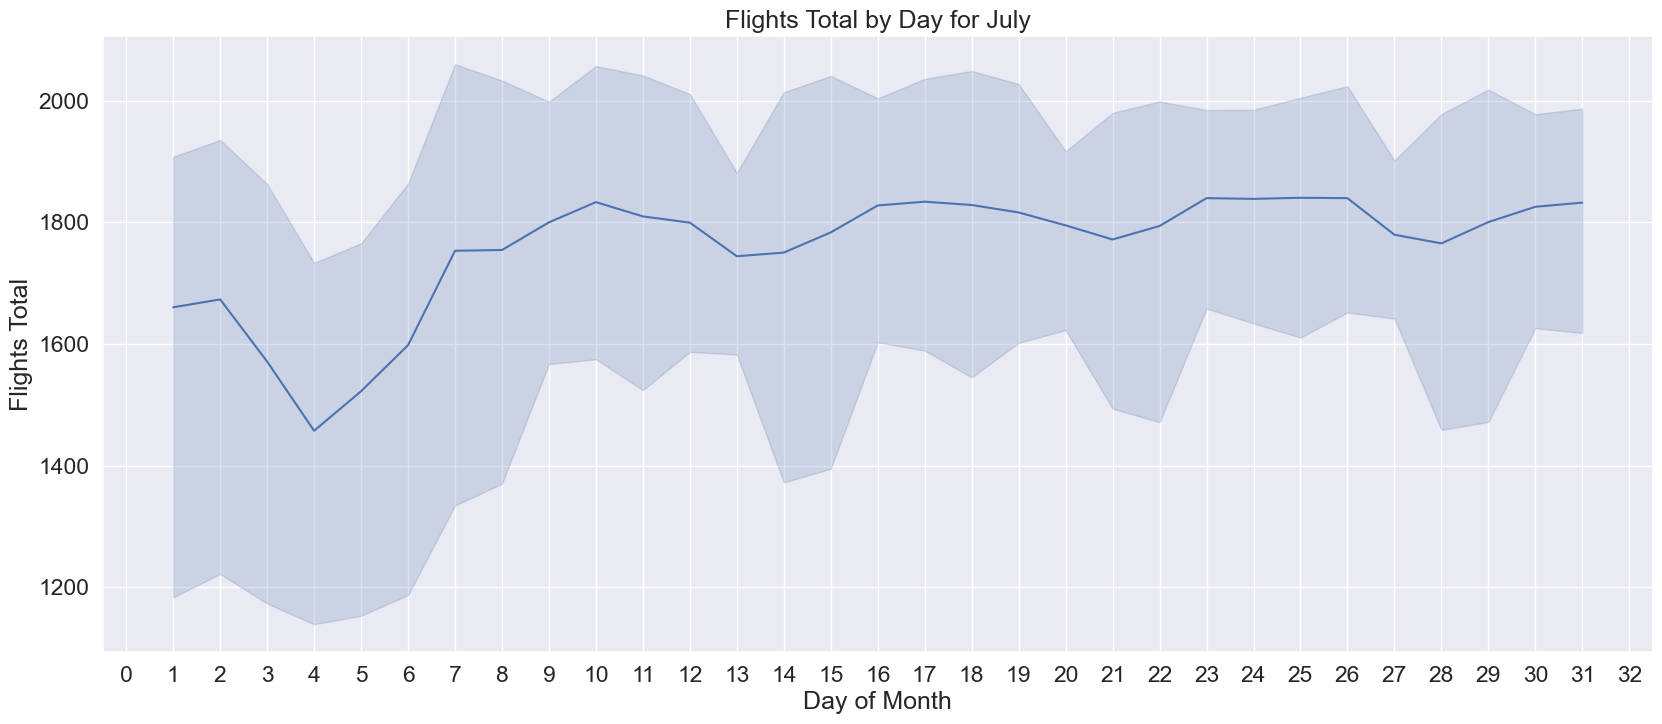

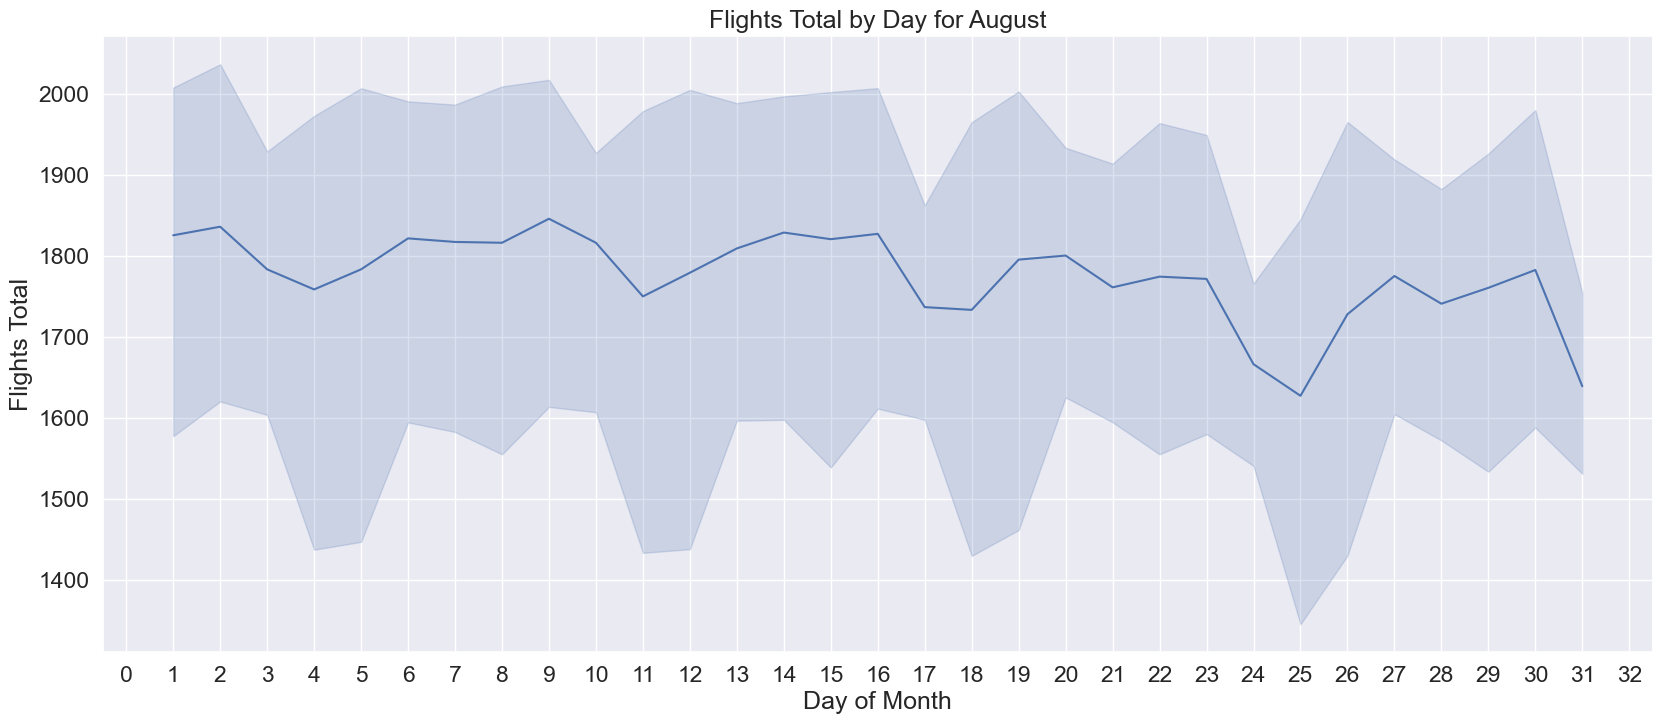

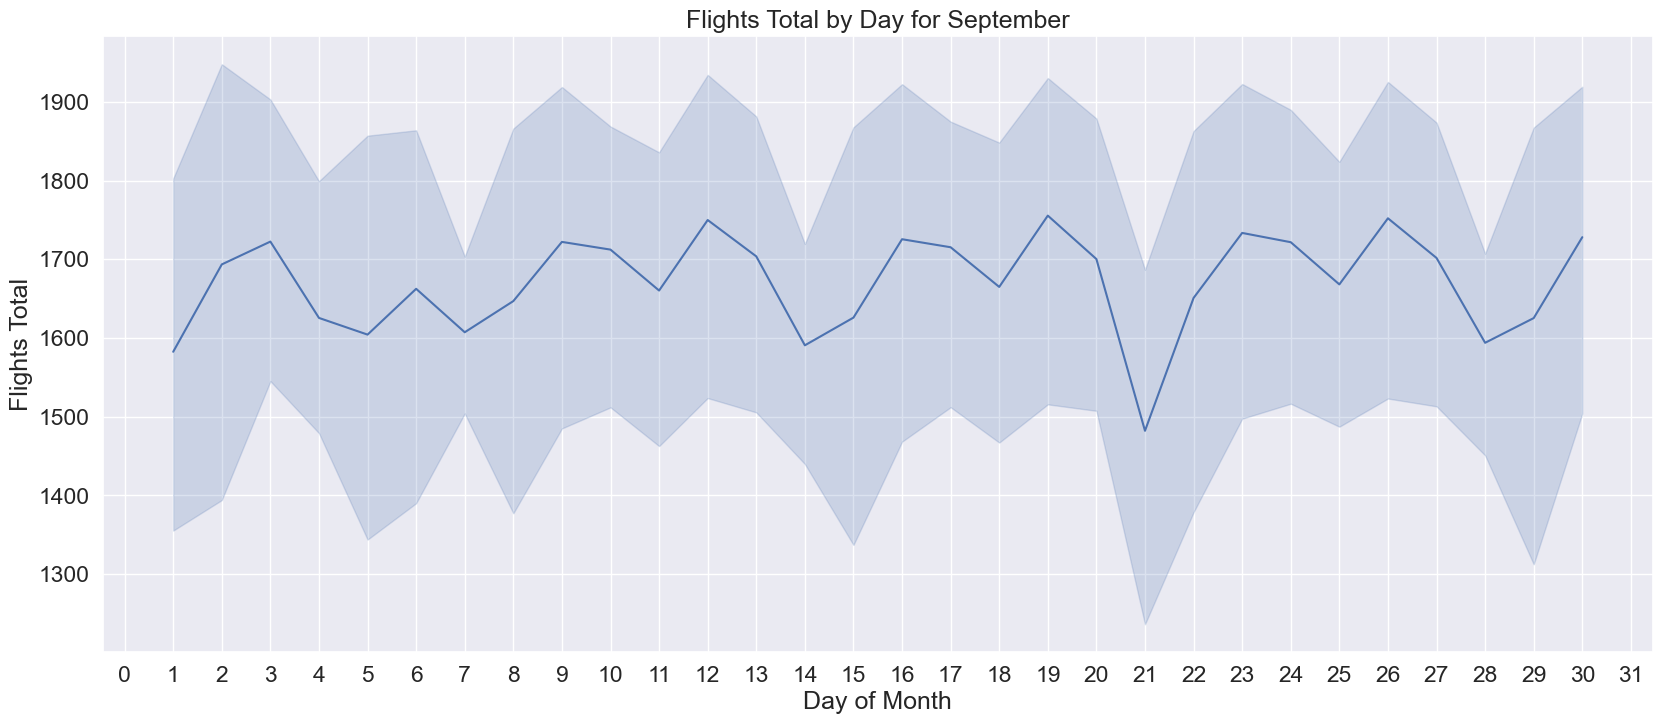

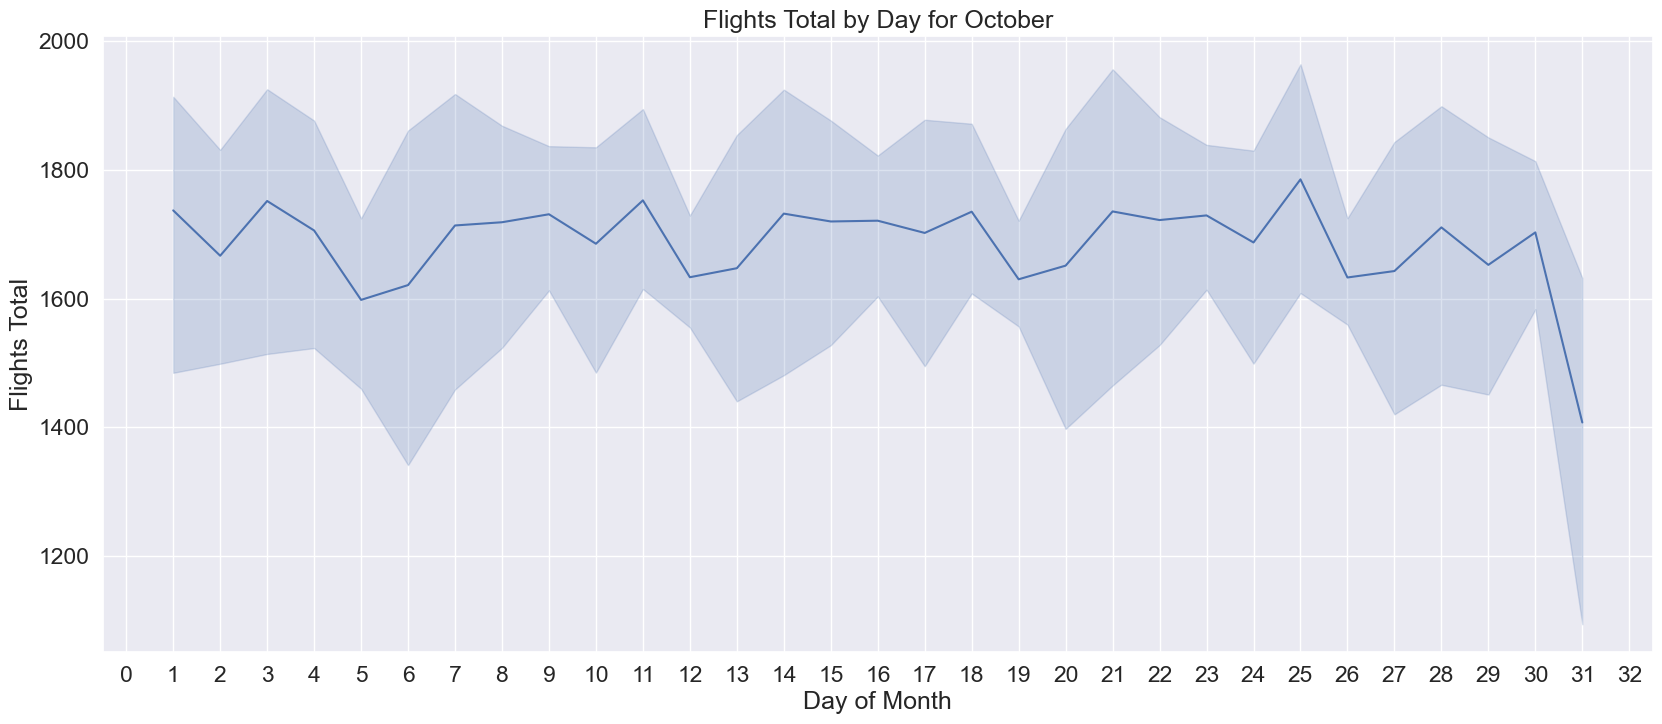

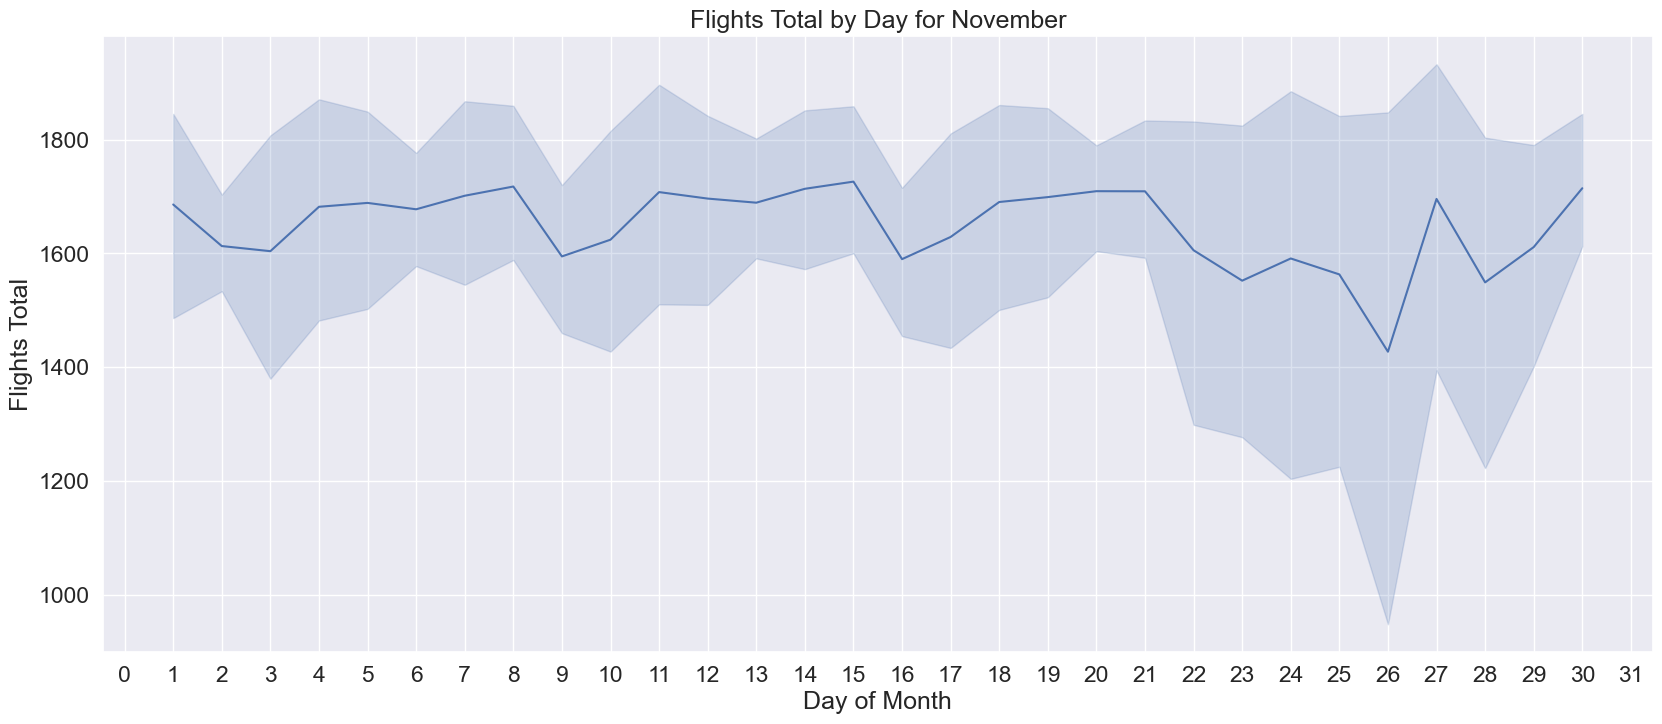

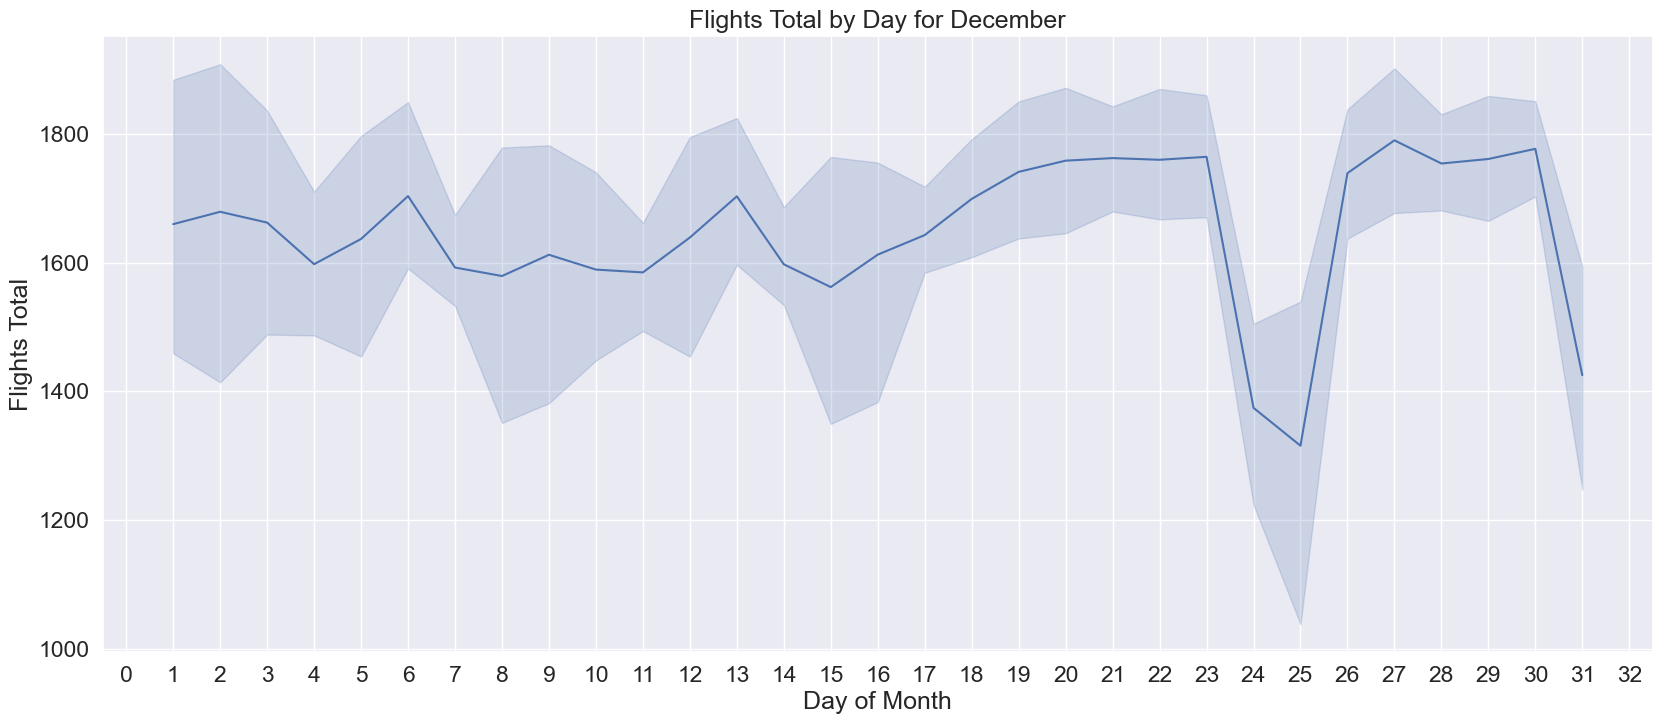

In [3]:

# Pointrange plot of the mean and standard deviation of flights_total by day for December
import matplotlib.ticker as ticker

for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']:
    sns.set_theme(rc={'figure.figsize':(20,8)})
    sns.set_theme(font_scale=1.5)
    sns.lineplot(data=df[(df['month'] == month)], x="day_of_month", y="flights_total")
    plt.title(f'Flights Total by Day for {month}')
    plt.xlabel('Day of Month')
    plt.ylabel('Flights Total')
    # Setting x-axis major ticks to each day
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


## Flights and weather correlations

In [4]:
# Get lists of weather features sorted by Pearson correlation coefficient for correlation with flights_total, flights_cancel, flights_delay, and flights_ontime
weather_cols_total_corr = df[['flights_total'] + weather_cols].corr(method = 'spearman')['flights_total'].sort_values(ascending=False)
weather_cols_cancel_corr = df[['flights_cancel'] + weather_cols].corr(method = 'spearman')['flights_cancel'].sort_values(ascending=False)
weather_cols_delay_corr = df[['flights_delay'] + weather_cols].corr(method = 'spearman')['flights_delay'].sort_values(ascending=False)
weather_cols_ontime_corr = df[['flights_ontime'] + weather_cols].corr(method = 'spearman')['flights_ontime'].sort_values(ascending=False)

# Combine the three lists of correlations into a dataframe
weather_cols_corr = pd.concat([weather_cols_total_corr.drop(['flights_total'], axis=0),
                               weather_cols_cancel_corr.drop(['flights_cancel'], axis=0), 
                               weather_cols_delay_corr.drop(['flights_delay'], axis=0), 
                               weather_cols_ontime_corr.drop(['flights_ontime'], axis=0)], axis=1)

print(weather_cols_corr)

# Get the average absolute value of the correlation coefficients for each column

print("\nAverage absolute value correlation with weather features:\n", weather_cols_corr.abs().mean(axis=0))



                    flights_total  flights_cancel  flights_delay  \
wx_temperature_min       0.262753        0.072188       0.126683   
wx_temperature_max       0.218874       -0.029377      -0.042117   
wx_cape                  0.213871        0.191506       0.244203   
wx_vis                   0.063524       -0.177864      -0.209756   
wx_apcp                  0.009994        0.285349       0.309797   
wx_wind_direction        0.002613        0.015853       0.026593   
wx_prate                -0.019207        0.252918       0.289769   
wx_maxref               -0.021786        0.269684       0.297660   
wx_gust                 -0.037115        0.124035       0.137291   
wx_wind_speed           -0.050225        0.071265       0.073756   
wx_asnow                -0.085609        0.170197       0.056183   
wx_frozr                -0.093290        0.131685       0.055155   
wx_lftx                 -0.189835       -0.133529      -0.177331   

                    flights_ontime  
wx_tempera

## Heatmap of correlations for weather data

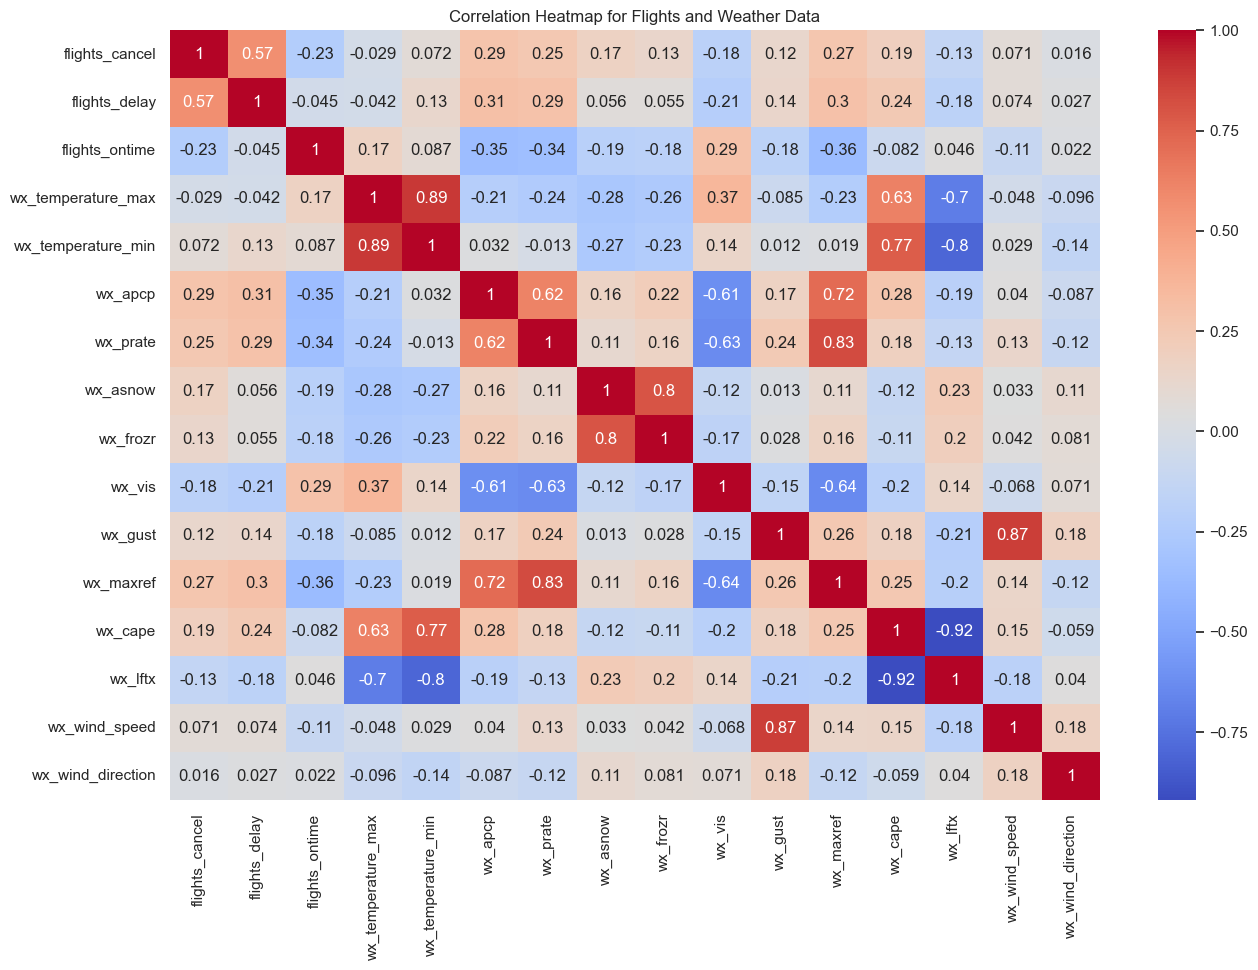

In [5]:
plt.figure(figsize=(15, 10))
sns.set_theme(font_scale=1.0)
sns.heatmap(df[['flights_cancel', 'flights_delay', 'flights_ontime'] + weather_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Flights and Weather Data')
plt.show()

## Correlation pairplot for weather and delayed departures

<Figure size 1000x1000 with 0 Axes>

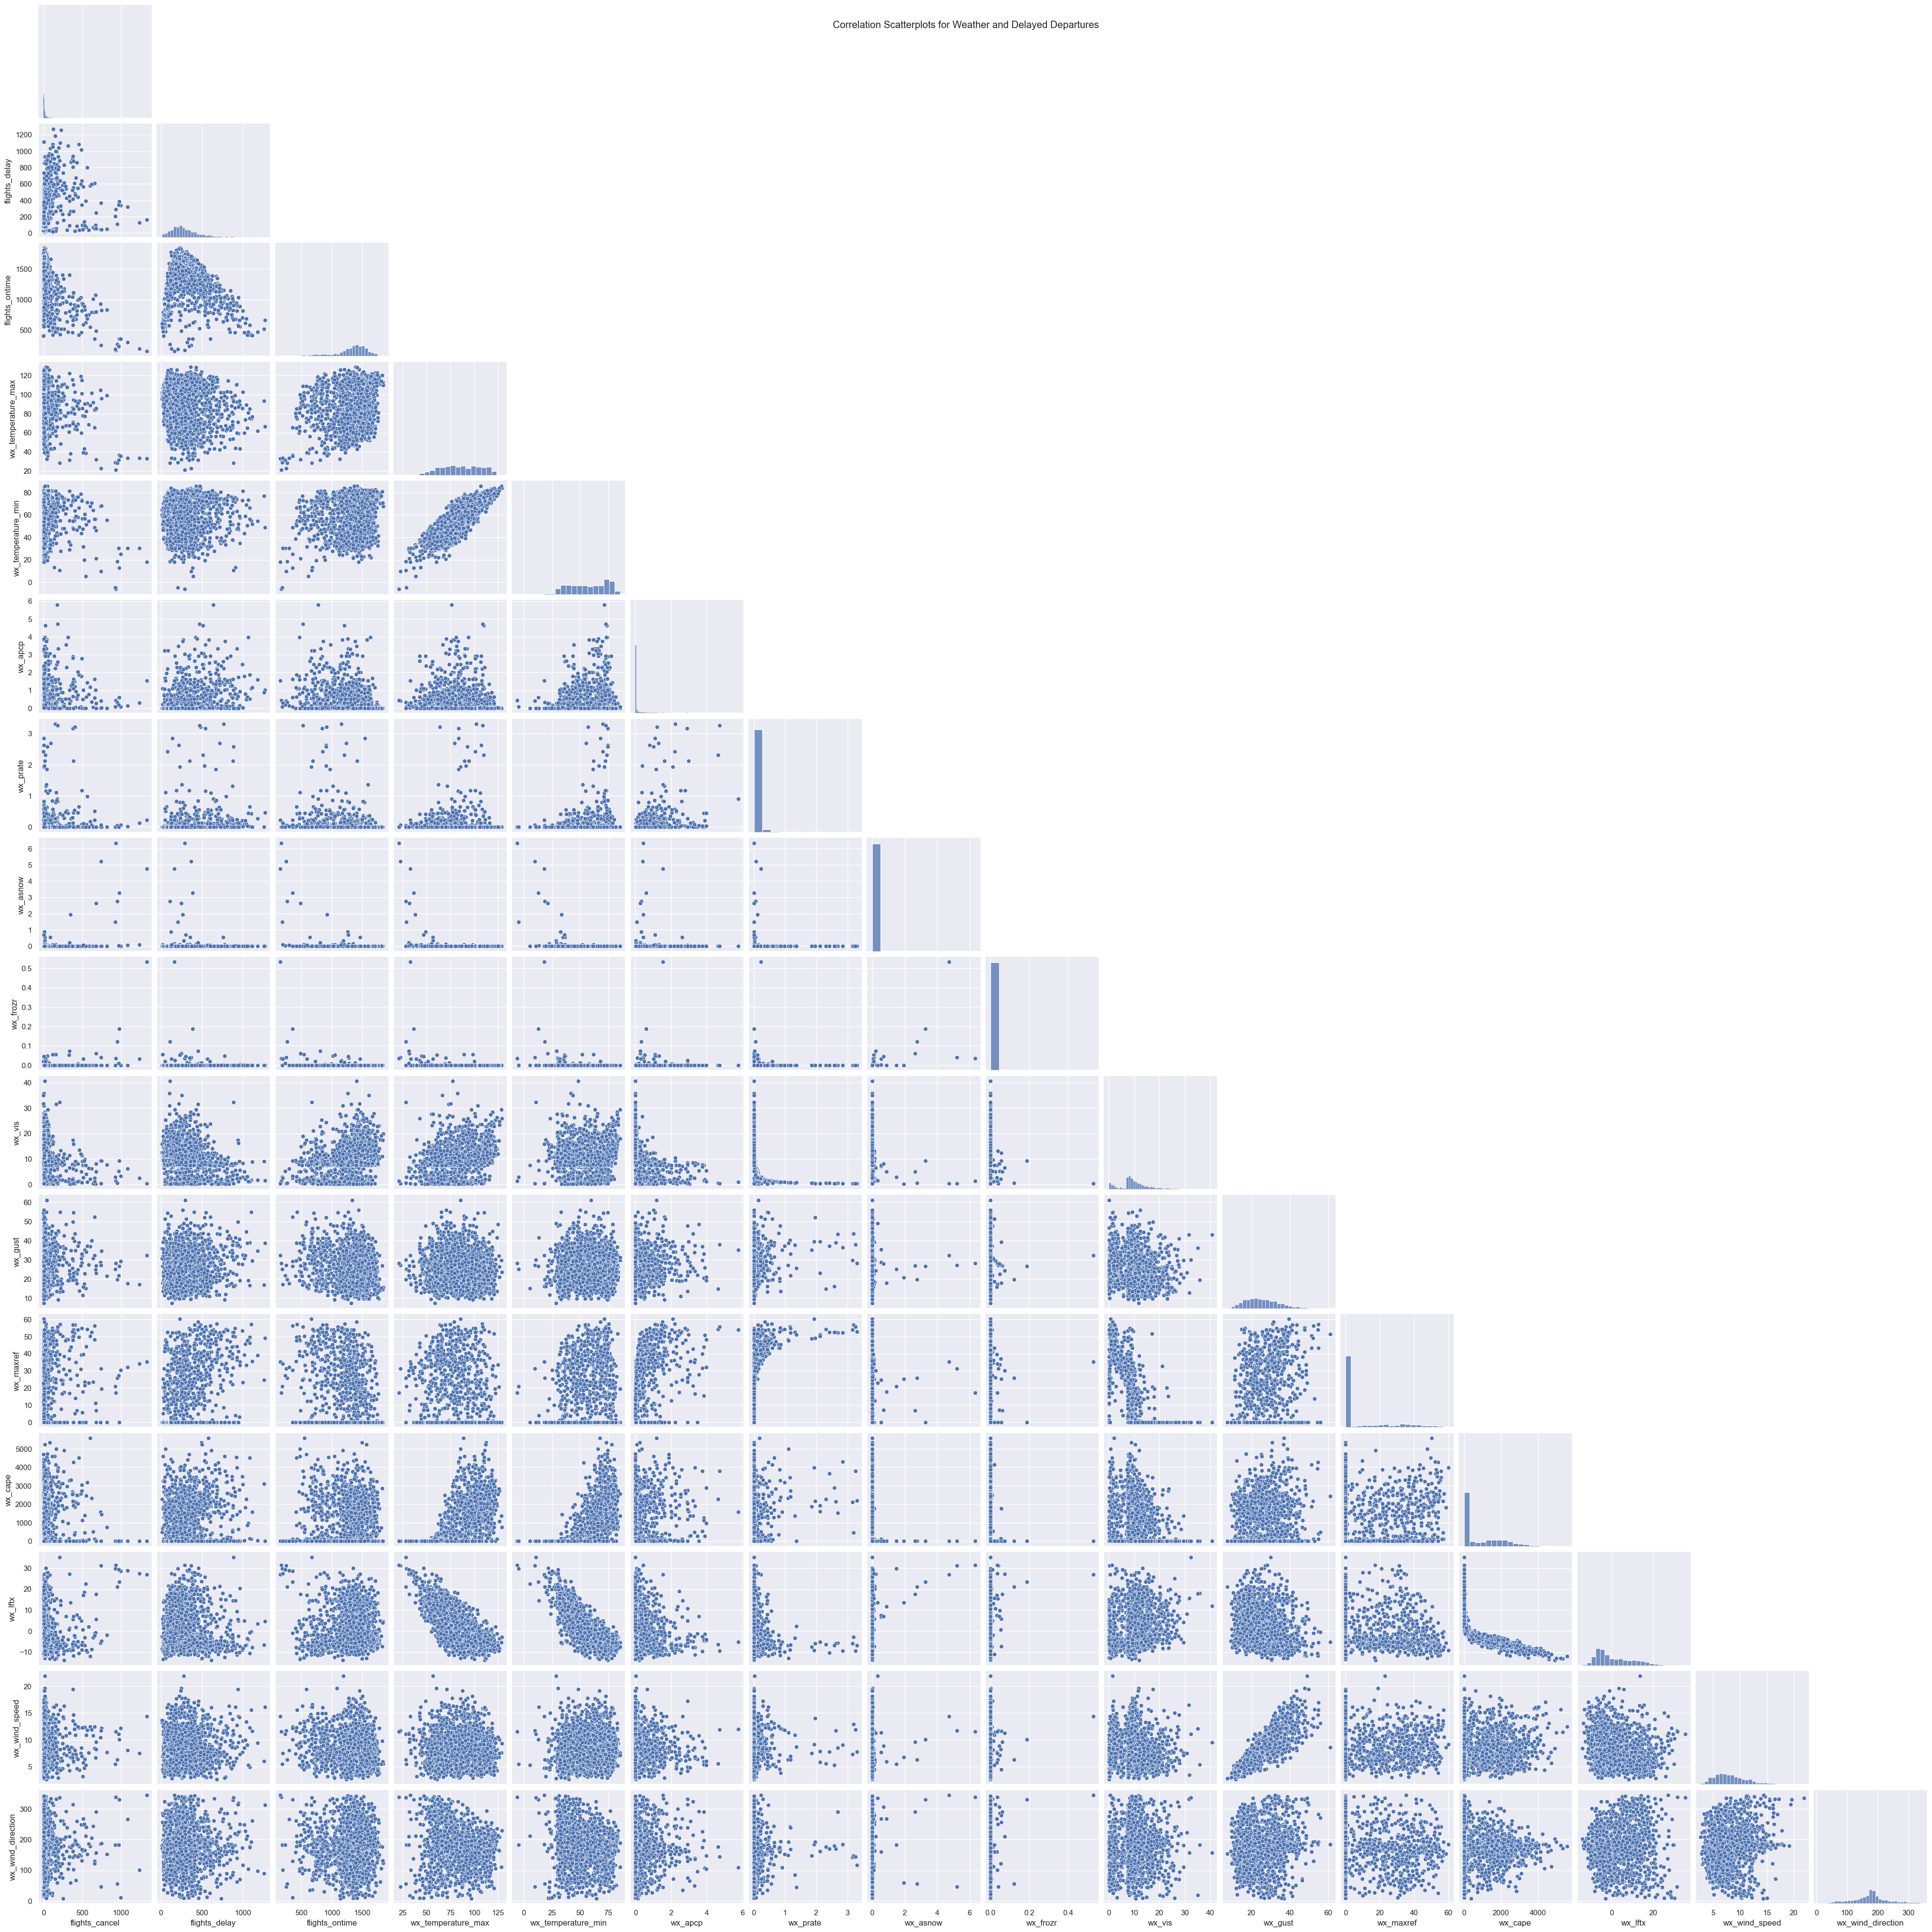

In [6]:
plt.figure(figsize=(10, 10))
sns.pairplot(df[['flights_cancel', 'flights_delay', 'flights_ontime'] + weather_cols], corner=True)
plt.suptitle('Correlation Scatterplots for Weather and Delayed Departures')
plt.show()

# INTRODUCTION
This notebook performs linear regression on the pre-processed data from "1. daily_import_merge_engineer.ipynb". 

## Libraries

In [4]:
import os
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error   
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

DAILY_DATA_PATH = "data.v3/daily" 

## Import data & column groups

In [5]:
df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# DATA PREPROCESSING

## Train Test Split
The shuffle=True/False argument drastically changes the linear model fit. If shuffle=False, the data are split sequentially into train, validate, and test sets (80:10:10). The entire data set covers a little over 5 years, shuffle=False means the last year is not used in training the data. Omitting the last year of data from the training dataset crushes the validation model accuracy (r-squared, mean squared error) and is not surprising given the dramatic disruption of air traffic caused by the COVID-19 pandemic and the relatively recent recovery. 

Using shuffle=True leads to robust r-squared and MSE metrics that will likely be mostly retained in the test set. However, the accuracy of the model on future data will likely be lower as air-traffic is likely to continue changing for unpredictable reasons. Any forecasting model will likely require frequent training updates with current data to stay relevant.

"shuffle=False" is used for this analysis. This will have implications for prediction algorithms and reduce the effectivenes of algorithms like recurrent neural networks that are designed to digest sequences of data, "windows", such as 7 days of sequential data.

In [26]:
# Select training features
train_features = ['random'] + date_cols + weather_cols + lag_cols

# Create X and y
X = df[train_features].drop('date', axis=1)
y = df[flights_non_terminal_cols + flights_percentage_cols]

print(X.columns.tolist())
print("\nTarget columns\n", y.head())

# Split data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Print shapes
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_Test shape:", X_test.shape)


['random', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7', 'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7']

Target colu

## Column transformers

In [27]:
categorical_tranformer = make_pipeline(OneHotEncoder(handle_unknown='ignore')) # Some observed holidays may not be in the training data
numeric_transformer = make_pipeline(StandardScaler())

# print value counts of unique data types in X
print(X.dtypes.value_counts())

# Identify categorical and numeric columns in X_train_full
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()

# Check that all columns are accounted for
print(f"categorical columns: {categorical_cols}")
print(f"numeric columns: {numeric_cols}")
print(len(categorical_cols) + len(numeric_cols) == X_train_full.shape[1])

# Linear regression transformer
LR__transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_tranformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

float64    30
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64
categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
numeric columns: ['random', 'ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7', 'flights_ontime_lag_1', 'flights_ontime_lag_2

## Lasso regression

Lasso regression on all targets using gridsearchCV to tune alpha

In [28]:
from sklearn.exceptions import ConvergenceWarning
import warnings

param_grid = {'lasso__alpha': [.01, .1, 1, 10, 20]}

lasso_pipeline = make_pipeline(
    LR__transformer,
    Lasso(max_iter=10000)
)

grid_search = GridSearchCV(
    lasso_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, # n_jobs=-1 means use all available CPU cores
    verbose=0
    )

lasso_models = {}
convergence_issues = {}

# Fit lasso models for all targets
for target in y.columns.tolist():
    grid_search.fit(X_train, y_train[target])

    # Save best model parameters, best alpha, and best model
    best_model = grid_search.best_estimator_
    best_alpha = best_model.named_steps['lasso'].get_params()['alpha']
    lasso_models[f"lasso_{target}"] = grid_search.best_estimator_

    # Identify convergence issues for the best alpha values
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        best_model.fit(X_train, y_train[target])
        if any(issubclass(warn.category, ConvergenceWarning) for warn in w):
            convergence_issues[target] = best_alpha

# Print convergence issues
if convergence_issues:
    print("Convergence issues:")
    for target, alpha in convergence_issues.items():
        print(f"{target} did not converge with alpha = {alpha}")
else:
    print("No convergence issues for the best alpha values of any target")

/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e+04, tolerance: 9.212e+03
  model = cd_fast.enet_coordinate_descent(
/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.984e+04, tolerance: 1.197e+03
  model = cd_fast.enet_coordinate_descent(
/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Obje

No convergence issues for the best alpha values of any target


Best lasso alpha, r-squared, and mean absolute error on validation set for each target

In [29]:
lasso_results = pd.DataFrame(columns=['TARGET', 'ALPHA', 'R2', 'MAE'])

# Print best alpha and R2 for all lasso models
for target in y.columns.tolist():
    model = lasso_models[f"lasso_{target}"]
    alpha = model.named_steps['lasso'].get_params()['alpha']
    r2 = r2_score(y_val[target], model.predict(X_val)).round(3)
    mae = mean_absolute_error(y_val[target], model.predict(X_val)).round(3)
    temp = pd.DataFrame({'TARGET': target, 'ALPHA': alpha, 'R2': r2, 'MAE': mae}, index=[0])
    
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        lasso_results = pd.concat([lasso_results, temp], ignore_index=True)

print("Validation Metrics for Lasso Regression:")
print(lasso_results)

Validation Metrics for Lasso Regression:
                    TARGET  ALPHA     R2      MAE
0            flights_total   0.10  0.916   59.421
1           flights_cancel   1.00  0.811   32.279
2            flights_delay   1.00  0.350   92.219
3           flights_ontime   0.10  0.671  121.566
4       flights_arr_ontime   0.10  0.684   59.914
5        flights_arr_delay   1.00  0.300   47.343
6       flights_arr_cancel   1.00  0.822   14.694
7       flights_dep_ontime   0.10  0.656   63.003
8        flights_dep_delay   0.10  0.408   47.548
9       flights_dep_cancel   1.00  0.791   16.593
10      flights_cancel_pct   0.10  0.792    2.062
11       flights_delay_pct   0.10  0.263    5.122
12      flights_ontime_pct   0.10  0.586    5.911
13   flights_arr_delay_pct   0.10  0.235    5.308
14  flights_arr_ontime_pct   0.10  0.552    6.126
15  flights_arr_cancel_pct   0.10  0.794    1.952
16   flights_dep_delay_pct   0.01  0.305    5.335
17  flights_dep_ontime_pct   0.10  0.606    6.113
18  fligh

## Ridge regression

Here I use ridge regression on a single target, flights_ontime, and rank the coefficients from most important to least important. Becuase the continuous features were standardized, coefficient magnitudes generally correspond to importance. A preview of the first 5 features yields no suprises, as Thanksgiving, Saturdays, Christmas eve, and yesterday's ontime flights are expected to be strong predictors of ontime_flights. 

In [30]:
# Ridge pipeline for flights_ontime
ridge_pipeline = make_pipeline(
    LR__transformer,
    Ridge(alpha=10)
)

# Ridge fit
ridge_pipeline.fit(X_train, y_train['flights_ontime'])

# Ridge predictions
y_pred_ontime = ridge_pipeline.predict(X_val)
print("R2 score:", r2_score(y_val['flights_ontime'], y_pred_ontime))

# Features and coefficients with non-zero coefficients
ridge_ontime_features = ridge_pipeline.named_steps['columntransformer'].get_feature_names_out()
ridge_ontime_coef = ridge_pipeline.named_steps['ridge'].coef_

# Create a dataframe of features and coefficients
ridge_ontime_df = pd.DataFrame({'features': ridge_ontime_features, 'coefficients': ridge_ontime_coef})

# Sort the dataframe by coefficient absolute value, largest to smallest
ridge_ontime_df['coefficients_abs'] = ridge_ontime_df['coefficients'].abs()
ridge_ontime_df.sort_values(by='coefficients_abs', inplace=True, ascending=False)

# Filter the dataframe for coefficients_abs > .1
ridge_ontime_df = ridge_ontime_df[ridge_ontime_df['coefficients_abs'] > .1]

print("Ridge coefficients:\n", ridge_ontime_df)

R2 score: 0.6686829700384376
Ridge coefficients:
                       features  coefficients  coefficients_abs
38   cat__holiday_Thanksgiving   -181.891491        181.891491
70              num__wx_maxref    -86.768167         86.768167
89   num__flights_ontime_lag_1     69.218829         69.218829
16   cat__day_of_week_Saturday    -64.810300         64.810300
44           cat__xmas_eve_yes    -60.865488         60.865488
..                         ...           ...               ...
52  cat__day_before_easter_yes     -1.002268          1.002268
51   cat__day_before_easter_no      1.002268          1.002268
64                num__wx_apcp     -0.941440          0.941440
45       cat__new_years_eve_no      0.240445          0.240445
46      cat__new_years_eve_yes     -0.240445          0.240445

[96 rows x 3 columns]


## Ridge regression on all targets using grid search CV to tune alpha

In [31]:
param_grid = {'ridge__alpha': [.01, .1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

ridge_pipeline = make_pipeline(
    LR__transformer,
    Ridge(max_iter=10000)
)

grid_search = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, # n_jobs=-1 means use all available CPU cores
    verbose=0
    )

ridge_models = {}
convergence_issues = {}

# Fit lasso models for all targets
for target in y.columns.tolist():
    grid_search.fit(X_train, y_train[target])

    # Save best model parameters, best alpha, and best model
    best_model = grid_search.best_estimator_
    best_alpha = best_model.named_steps['ridge'].get_params()['alpha']
    ridge_models[f"ridge_{target}"] = grid_search.best_estimator_

    # Identify convergence issues for the best alpha values
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        best_model.fit(X_train, y_train[target])
        if any(issubclass(warn.category, ConvergenceWarning) for warn in w):
            convergence_issues[target] = best_alpha

# Print convergence issues
if convergence_issues:
    print("Convergence issues:")
    for target, alpha in convergence_issues.items():
        print(f"{target} did not converge with alpha = {alpha}")
else:
    print("No convergence issues for the best alpha values of any target")

No convergence issues for the best alpha values of any target


Get alpha, r-squared,and MAE for best ridge fit for each target

In [32]:
ridge_results = pd.DataFrame(columns=['TARGET', 'ALPHA', 'R2', 'MAE'])

# Print best alpha and R2 for all ridge models
for target in y.columns.tolist():
    model = ridge_models[f"ridge_{target}"]
    alpha = model.named_steps['ridge'].get_params()['alpha']
    r2 = r2_score(y_val[target], model.predict(X_val)).round(3)
    mae = mean_absolute_error(y_val[target], model.predict(X_val)).round(3)
    temp = pd.DataFrame({'TARGET': target, 'ALPHA': alpha, 'R2': r2, 'MAE': mae}, index=[0])
    
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        ridge_results = pd.concat([ridge_results, temp], ignore_index=True)

print(ridge_results)

                    TARGET  ALPHA     R2      MAE
0            flights_total    0.1  0.916   60.873
1           flights_cancel  100.0  0.814   32.343
2            flights_delay   30.0  0.370   91.431
3           flights_ontime    1.0  0.672  121.471
4       flights_arr_ontime    1.0  0.678   60.743
5        flights_arr_delay   30.0  0.324   46.997
6       flights_arr_cancel  100.0  0.828   15.355
7       flights_dep_ontime    1.0  0.655   62.930
8        flights_dep_delay   30.0  0.414   47.084
9       flights_dep_cancel  100.0  0.788   17.482
10      flights_cancel_pct  100.0  0.800    2.112
11       flights_delay_pct   60.0  0.278    5.081
12      flights_ontime_pct   50.0  0.590    5.929
13   flights_arr_delay_pct   80.0  0.249    5.246
14  flights_arr_ontime_pct   60.0  0.561    6.058
15  flights_arr_cancel_pct  100.0  0.808    2.007
16   flights_dep_delay_pct   60.0  0.310    5.279
17  flights_dep_ontime_pct   60.0  0.610    6.102
18  flights_dep_cancel_pct  100.0  0.781    2.250


In [33]:
elastic_net_pipeline = make_pipeline(
    LR__transformer,
    ElasticNet(alpha=10, 
               l1_ratio=0.5,
               max_iter=10000))

# get a list of 200 values from .0001 to .4
alpha_values = [round(x, 4) for x in np.linspace(.0001, .4, 200)]
l1_ratio_values = [round(x, 2) for x in np.linspace(.1, .9, 9)]

param_grid = {'elasticnet__alpha': alpha_values,
              'elasticnet__l1_ratio': l1_ratio_values}

grid_search = GridSearchCV(
    elastic_net_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, # n_jobs=-1 means use all available CPU cores
    verbose=0
    )

elastic_net_models = {}
convergence_issues = {}
models_dir = "models/elastic_net"
os.makedirs(models_dir, exist_ok=True)

for target in y.columns.tolist():
    grid_search.fit(X_train, y_train[target])

    # Save best model parameters, best alpha, and best model
    best_model = grid_search.best_estimator_
    best_alpha = best_model.named_steps['elasticnet'].get_params()['alpha']
    best_l1_ratio = best_model.named_steps['elasticnet'].get_params()['l1_ratio']
    elastic_net_models[f"elastic_net_{target}"] = grid_search.best_estimator_

    # Identify convergence issues for the best alpha values and l1_ratio
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        best_model.fit(X_train, y_train[target])
        if any(issubclass(warn.category, ConvergenceWarning) for warn in w):
            convergence_issues[target] = (best_alpha, best_l1_ratio)

# Print convergence issues
if convergence_issues:
    print("Convergence issues:")
    for target, alpha_l1_ratio in convergence_issues.items():
        print(f"{target} did not converge with alpha = {alpha_l1_ratio[0]} and l1_ratio = {alpha_l1_ratio[1]}")
else:
    print("No convergence issues for the best alpha and l1_ratio values of any target")

    # print(f"Best parameters for elastic_net_{target}:\n{grid_search.best_params_}")

# Save best elastic net models
for target, model in elastic_net_models.items():
    model_path = os.path.join(models_dir, f"{target}.joblib")
    joblib.dump(model, model_path)
    print(f"Saved {target} model to {model_path}")

/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 9.587e+03
  model = cd_fast.enet_coordinate_descent(
/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+06, tolerance: 9.212e+03
  model = cd_fast.enet_coordinate_descent(
/Users/shobbs/.local/share/virtualenvs/predicting_flight_traffic-wZNm__h8/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Obje

No convergence issues for the best alpha and l1_ratio values of any target
Saved elastic_net_flights_total model to models/elastic_net/elastic_net_flights_total.joblib
Saved elastic_net_flights_cancel model to models/elastic_net/elastic_net_flights_cancel.joblib
Saved elastic_net_flights_delay model to models/elastic_net/elastic_net_flights_delay.joblib
Saved elastic_net_flights_ontime model to models/elastic_net/elastic_net_flights_ontime.joblib
Saved elastic_net_flights_arr_ontime model to models/elastic_net/elastic_net_flights_arr_ontime.joblib
Saved elastic_net_flights_arr_delay model to models/elastic_net/elastic_net_flights_arr_delay.joblib
Saved elastic_net_flights_arr_cancel model to models/elastic_net/elastic_net_flights_arr_cancel.joblib
Saved elastic_net_flights_dep_ontime model to models/elastic_net/elastic_net_flights_dep_ontime.joblib
Saved elastic_net_flights_dep_delay model to models/elastic_net/elastic_net_flights_dep_delay.joblib
Saved elastic_net_flights_dep_cancel m

In [34]:
elastic_net_results = pd.DataFrame(columns=['TARGET', 'ALPHA', 'L1 RATIO', 'R2', 'MAE', 'MSE'])

for target in y.columns.tolist():
    model = elastic_net_models[f"elastic_net_{target}"]
    alpha = model.named_steps['elasticnet'].get_params()['alpha']
    l1_ratio = model.named_steps['elasticnet'].get_params()['l1_ratio']
    r2 = r2_score(y_val[target], model.predict(X_val)).round(3)
    mae = mean_absolute_error(y_val[target], model.predict(X_val)).round(3)
    mse = mean_squared_error(y_val[target], model.predict(X_val)).round(1)
    temp = pd.DataFrame({'TARGET': target, 'ALPHA': alpha, 'L1 RATIO': l1_ratio, 'R2': r2, 'MAE': mae, 'MSE': mse}, index=[0])
    
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        elastic_net_results = pd.concat([elastic_net_results, temp], ignore_index=True)

# Create "model_output" directory
os.makedirs("model_output", exist_ok=True)

# Save results to a csv file
elastic_net_results.to_csv("model_output/elastic_net_results.csv", index=False)

print(elastic_net_results)

                    TARGET   ALPHA  L1 RATIO     R2      MAE      MSE
0            flights_total  0.0021       0.9  0.917   60.230   7841.9
1           flights_cancel  0.2352       0.6  0.816   31.606   4516.6
2            flights_delay  0.0282       0.1  0.371   91.290  22536.5
3           flights_ontime  0.0122       0.9  0.673  121.274  33447.6
4       flights_arr_ontime  0.0122       0.9  0.680   60.480   8527.8
5        flights_arr_delay  0.0343       0.1  0.325   46.894   6008.8
6       flights_arr_cancel  0.4000       0.8  0.831   14.607   1020.9
7       flights_dep_ontime  0.0142       0.9  0.655   63.192   8650.0
8        flights_dep_delay  0.0302       0.1  0.413   47.030   5637.5
9       flights_dep_cancel  0.1247       0.1  0.786   17.073   1342.2
10      flights_cancel_pct  0.1287       0.4  0.806    2.001     18.6
11       flights_delay_pct  0.0503       0.3  0.278    5.077     77.6
12      flights_ontime_pct  0.0523       0.1  0.592    5.897     97.3
13   flights_arr_del

# INTRODUCTION

## Libraries

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Import data & column groups

In [21]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

## Train Test Split - "flights_ontime"

In [22]:
# Select features and targets
train_features = ['random'] + date_cols + weather_cols + lag_cols
targets = flights_non_terminal_cols + flights_percentage_cols

# Create X and y
X = df[train_features].drop('date', axis=1)
y = df[targets]

# Split data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y['flights_ontime'], test_size=0.1, random_state=42)

# Split data into X_train_rull and y_train_full into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Print shapes
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_Test shape:", X_test.shape)
print("y_Test shape:", y_test.shape)

X_train_full shape: (1516, 54)
y_train_full shape: (1516,)
X_train shape: (1364, 54)
y_train shape: (1364,)
X_Test shape: (169, 54)
y_Test shape: (169,)


# PREPROCESS FOR DENSE NETWORK

In [23]:
print(f"Feature names: {X.columns.tolist()}")
print(f"Target columns: {y.columns.tolist()}", end="\n\n")
print("Unique data types in X", X.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()

print(f"\nCategorical columns to one-hot-encode: {categorical_cols}")

# Fit transformers to the training data
f_scaler = StandardScaler()
f_scaler.fit(X_train[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(X_train[categorical_cols])

t_scaler = StandardScaler()
t_scaler.fit(y_train.values.reshape(-1, 1)) # reshape y_train to be 2D

# Define preprocessor
def preprocess(features, target, set_global_scaler = False):
    global global_targer_scaler

    scaled_features = f_scaler.transform(features[numeric_cols])
    encoded_features = ohe.transform(features[categorical_cols])
    scaled_target = t_scaler.transform(target.values.reshape(-1, 1))
    processed_features = np.concatenate([scaled_features, encoded_features], axis=1)

    if set_global_scaler:
        global_targer_scaler = t_scaler

    return processed_features, scaled_target

# Preprocess the data
X_train_d, y_train_d = preprocess(X_train, y_train, set_global_scaler=True)
X_val_d, y_val_d = preprocess(X_val, y_val)

Feature names: ['random', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7', 'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7

# ONE-NEURON "LINEAR MODEL"

The goal of this section is to simulate linear regression using a neural newtork with one neuron and no activation function. I'll use L1 and L2 regularization to simulate elastic net regression and compare results to those found in 3.daily_linear_regression.ipynb.

## Create TensorFlow datasets

In [24]:
# TensorFlow datasets
train_ds_flights_ontime_d = Dataset.from_tensor_slices((X_train_d, y_train_d)).shuffle(len(X_train_d))
val_ds_flights_ontime_d = Dataset.from_tensor_slices((X_val_d, y_val_d)).shuffle(len(X_val_d))

# Batch and prefetch
batch_size = 32
train_ds_flights_ontime_d = train_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)
val_ds_flights_ontime_d = val_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)


## Create R-squared metric

In [25]:
from keras import backend as K

def r_squared(y_true, y_pred):
    y_true_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_true], tf.float32)
    y_pred_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_pred], tf.float32)
    SS_res =  K.sum(K.square(y_true_inv - y_pred_inv)) 
    SS_tot = K.sum(K.square(y_true_inv - K.mean(y_true_inv))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Build one-neuron hypermodel

In [26]:
def model_builder(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    l1_regularization = hp.Float('l1_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential([
        Dense(units = 1, 
            input_dim=X_train_d.shape[1], 
            kernel_regularizer=L1L2(l1_regularization, l2_regularization))
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error', r_squared])
    
    return model

## Get one-neuron hyperparameters using Keras random search tuner

In [ ]:
# Callbacks & Tensorboard Setup
early_stopping_1n_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a Keras Tuner
OneNeuron_tuner_RS = kt.RandomSearch(
    hypermodel = model_builder,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='logs/flights_ontime/dense_lr/',
    project_name='tuner',
    overwrite = True
)

In [29]:
# Search for best hyperparameters
OneNeuron_tuner_RS.search(train_ds_flights_ontime_d, 
             validation_data=val_ds_flights_ontime_d, 
             epochs=500, 
             callbacks=[early_stopping_1n_RS])

Trial 100 Complete [00h 00m 06s]
val_loss: 0.41847823560237885

Best val_loss So Far: 0.4020496606826782
Total elapsed time: 00h 16m 12s


## Best 3 one-model fits: hyperparameters and validation score

In [30]:
OneNeuron_tuner_RS.results_summary(num_trials=3)

Results summary
Results in logs/flights_ontime/dense_lr/tuner
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 019 summary
Hyperparameters:
learning_rate: 0.009929423316917789
l1_regularization: 1.3613167506559008e-05
l2_regularization: 0.00012991522868696756
Score: 0.4020496606826782

Trial 059 summary
Hyperparameters:
learning_rate: 0.004606695421104385
l1_regularization: 0.00029860952692165044
l2_regularization: 5.808762353159573e-05
Score: 0.4038938581943512

Trial 054 summary
Hyperparameters:
learning_rate: 0.0006717233174087713
l1_regularization: 9.528015594093438e-05
l2_regularization: 0.00024633112762105513
Score: 0.4060898572206497


## Get model weights and save best one-neuron model

In [31]:
# Get best hyperparameters
best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]

# Tensorboard setup
!rm -rf ./logs/flights_ontime/OneNeuron/tensorboard/ 
log_dir = "logs/flights_ontime/OneNeuron/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_best = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]
OneNeuron_LR_model = OneNeuron_tuner_RS.hypermodel.build(best_hps)
history = OneNeuron_LR_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
OneNeuron_LR_model.save('models/flights_ontime/OneNeuron_LR_model')

INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


##  TensorBoard for best 1-neuron model
The TensorBoard dashboard shows plots generated from training logs that provide insight into the training of a model. 

The time series tab shows several plots within expandable windows for our one-neuronal model, "dense_#" and for the loss and training metrics by epoch.  Under dense_#, TesnorBoard shows histograms of the bias values "bias_0" and weight values, "kernel_0" by epoch. The epoch number is on the y-axis with the first epochs at the top and the most recent epoch at the bottom. These plots show how the bias and weight distributions change with training. For the one-neuron model, the weights appear to stabilize well before the training ended, at around 50 to 60 epochs, while the bias terms continued to drift downwards with training.

The other plots under Time Series show how the loss and metrics change with training epoch or iteration (batch number). Based on these plots, the one-neuron model appears to have high bias and high variance. High bias is indicated by the large difference in loss and performance metrics between the train and validation datasets. High variance is indicated by the large variation in the validation loss, mae, and r-squared metrics that persists through training, even after these metrics stabilize on the training set at around epoch 40. Taken together, the one-neuron model appears to lack flexibility and would also benefit from having more data to train the weights.




In [32]:
%tensorboard --logdir logs/flights_ontime/OneNeuron/tensorboard

Reusing TensorBoard on port 6008 (pid 3470), started 23:22:38 ago. (Use '!kill 3470' to kill it.)

## Load and evalute the best 1-neuron model

In [33]:
# Load the trained model
OneNeuron_LR_model = models.load_model('models/flights_ontime/OneNeuron_LR_model', custom_objects={'r_squared': r_squared})

# Inverse transform the predicted values and get validation MAE, MSE, and R^2
y_pred = OneNeuron_LR_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

OneNeuron_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
OneNeuron_val_mse = mean_squared_error(y_val_inv, y_pred_inv)
OneNeuron_val_r2 = r2_score(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {OneNeuron_val_mae:.2f}
- Validation MSE: {OneNeuron_val_mse:.2f}
- Validation R^2: {OneNeuron_val_r2:.3f}
""")

5/5 [==============================] - 0s 584us/step
Validation Metrics:
- Validation MAE: 117.60
- Validation MSE: 31933.98
- Validation R^2: 0.688



# SHALLOW DENSE NEURAL NETWORK (SDNN)

## Build SDNN Hypermodel

In [34]:
def build_model(hp):
    n_input_neurons = hp.Int('n_input_neurons', min_value=4, max_value=16, default=8)
    n_hidden_neurons = hp.Int('n_hidden_neurons', min_value=4, max_value=16, default=8)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.02, max_value=0.03, default=0.0)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential()

    # Input layer
    model.add(Dense(units=n_input_neurons, 
                    activation='relu', 
                    kernel_regularizer=L2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    
    # Hidden layer
    model.add(Dense(units=n_hidden_neurons, 
                    activation='relu', 
                    kernel_regularizer=L2(l2_regularization)))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

## Get hyperparameters for SDNN using Bayesian optimization

In [35]:
early_stopping_BO = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_BO = kt.BayesianOptimization(
    hypermodel = build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    num_initial_points=2,
    directory = "logs/flights_ontime/SDNN",
    project_name = "bayesian_optimization_tuner",
    overwrite=True
)

SDNN_tuner_BO.search(train_ds_flights_ontime_d, 
             epochs=500, 
             validation_data=val_ds_flights_ontime_d, 
             callbacks=[early_stopping_BO])

Trial 100 Complete [00h 00m 05s]
val_loss: 0.4497844725847244

Best val_loss So Far: 0.38925886154174805
Total elapsed time: 00h 11m 41s


## Get hyperparameters for SDNN using random search
In the interest of time, I didn't use the random search tuner on the last training run. This approach consistently underperformed compared to Bayesian optimization and hyperband.

In [ ]:
# early_stopping_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# SDNN_tuner_RS = kt.RandomSearch(
#     hypermodel = build_model,
#     objective='val_loss',
#     max_trials=100,
#     executions_per_trial=2,
#     directory = "logs/flights_ontime/SDNN",
#     project_name = "random_search_tuner",
#     overwrite=True
# )

# SDNN_tuner_RS.search(train_ds_flights_ontime_d,
#                 epochs=500, 
#                 validation_data=val_ds_flights_ontime_d, 
#                 callbacks=[early_stopping_RS])

## Get hyperparameters for best SDNN model using hyperband

In [36]:
early_stopping_HB = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_HB = kt.Hyperband(
    hypermodel = build_model,
    objective='val_loss',
    max_epochs=600,
    factor=3,
    directory = "logs/flights_ontime/SDNN",
    project_name = "hyperband_tuner",
    overwrite=True
)

SDNN_tuner_HB.search(train_ds_flights_ontime_d,
                epochs=600, 
                validation_data=val_ds_flights_ontime_d, 
                callbacks=[early_stopping_HB])

Trial 725 Complete [00h 00m 02s]
val_loss: 0.44303569197654724

Best val_loss So Far: 0.3603585958480835
Total elapsed time: 00h 21m 51s


## Get weights and save best SDNN model (from hyperband search)

In [37]:
# Get best hyperparameters from Hyperband tuner
best_hps = SDNN_tuner_HB.get_best_hyperparameters(num_trials = 1)[0]

# Initialize Early Stopping
early_stopping_SDNN_best = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Setup TensoreBoard
!rm -rf ./logs/flights_ontime/SDNN_HB/tensorboard/
log_dir = "logs/flights_ontime/SDNN_HB/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the best hyperparameters
SDNN_model = SDNN_tuner_HB.hypermodel.build(best_hps)
history = SDNN_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_SDNN_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
SDNN_model.save('models/flights_ontime/SDNN_model')

INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


## TensorBoard

In [38]:
# TensorBoard
%tensorboard --logdir logs/flights_ontime/SDNN_HB/tensorboard

Reusing TensorBoard on port 6009 (pid 27548), started 23:29:38 ago. (Use '!kill 27548' to kill it.)

## Best SDNN model summary

In [154]:
# Load the trained model
SDNN_model = models.load_model('models/flights_ontime/SDNN_model')

# Print the best hyperparameters
print(f"""Best Hyperparameters:
- Number of Hidden Layers: {best_hps.get('n_hidden')}
- Number of Neurons: {best_hps.get('n_neurons')}
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- L2 Regularization: {best_hps.get('l2_regularization')}
""")

Best Hyperparameters:
- Number of Hidden Layers: 1
- Number of Neurons: 8
- Learning Rate: 0.006415517608465564
- Dropout Rate: 0.024849650762982137
- L2 Regularization: 0.0007243411260176605



## Model architecture

In [39]:
SDNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 13)                1261      
                                                                 
 dropout_2 (Dropout)         (None, 13)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 112       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1382 (5.40 KB)
Trainable params: 1382 (5.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Best SDNN model evaluation

In [40]:
# Inverse transform the predicted values and get validation MAE, MSE
y_pred = SDNN_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

SDNN_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
SDNN_val_mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {SDNN_val_mae:.2f}
- Validation MSE: {SDNN_val_mse:.2f}
""")

5/5 [==============================] - 0s 1ms/step
Validation Metrics:
- Validation MAE: 117.43
- Validation MSE: 33070.08



# RECURRENT NEURAL NETWORK (RNN)

## Remove lag variables from X train, val, and test sets
The lag variables are redundant with the recurrent loops of an RNN that feed historical information into each neuron. I dropped the lag variables to reduce the redundancy and dimensionality in the RNN datasets. However, the lag variables may have value in an RNN despite introducing redundancy and multicolinearity. Time permitting, I'll retain the lag variables and train the RNN's a second time.

In [41]:
rnn_X_train_full = X_train_full.drop(lag_cols, axis=1)
rnn_X_train = X_train.drop(lag_cols, axis=1)
rnn_X_val = X_val.drop(lag_cols, axis=1)
rnn_X_test = X_test.drop(lag_cols, axis=1)

## RNN column transformers

In [42]:
rnn_numeric_cols = [col for col in numeric_cols if col not in lag_cols]

# Fit transformers to the training data
rnn_f_scaler = StandardScaler()
rnn_f_scaler.fit(rnn_X_train[rnn_numeric_cols])

# Create a function to preprocess TensorFlow datasets
def rnn_preprocess(features, target):
    scaled_features = rnn_f_scaler.transform(features[rnn_numeric_cols])
    encoded_features = ohe.transform(features[categorical_cols])
    scaled_target = t_scaler.transform(target.values.reshape(-1, 1)) # Scaling the target can speed up training, improve convergence, and reduce the impact of outliers for RNNs
    processed_features = np.concatenate([scaled_features, encoded_features], axis=1)
    return processed_features, scaled_target

# Transform the data
X_train_rnn, y_train_rnn = rnn_preprocess(X_train, y_train)
X_val_rnn, y_val_rnn = rnn_preprocess(X_val, y_val)
X_test_rnn, y_test_rnn = rnn_preprocess(X_test, y_test)

## Create timeseries datasets

The timeseries datasets below use a sequence length of 7 and a time step of 1. Each recurrent neuron will process the sequences in 7 recurrent steps, updating its hidden state based on the current input and the previous hidden state. 

In [43]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

seq_length = 7
batch_size = 32

train_rnn = timeseries_dataset_from_array(
    data = X_train_rnn, 
    targets = y_train_rnn,
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

val_rnn = timeseries_dataset_from_array(
    data = X_val_rnn, 
    targets = y_val_rnn[seq_length-1:],
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

test_rnn = timeseries_dataset_from_array(
    data = X_test_rnn, 
    targets = y_test_rnn[seq_length-1:],
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

# ONE RECURRENT NEURON

## Build one-neuron RNN hypermodel

In [44]:
# Build one-neuron RNN hypermodel
def OneRNN_model_builder(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    recurr_reg = hp.Float('recurr_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    model = Sequential([
        SimpleRNN(units = 1, 
                  input_shape = (None, X_train_rnn.shape[1]), 
                  kernel_regularizer=L2(kernel_reg),
                  recurrent_regularizer=L2(recurr_reg),
                  )
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error', r_squared])
    
    return model

In [45]:
# Create a Keras Hyperband tuner
OneRNN_tuner_HB = kt.Hyperband(
    hypermodel = OneRNN_model_builder,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='logs/flights_ontime/OneRNN',
    project_name='hyperband_tuner',
    overwrite = True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for best hyperparameters
OneRNN_tuner_HB.search(train_rnn, 
             validation_data=val_rnn, 
             epochs=50, 
             callbacks=[early_stopping])

Trial 90 Complete [00h 00m 05s]
val_loss: 1.3041276931762695

Best val_loss So Far: 1.1027542352676392
Total elapsed time: 00h 05m 33s


## Get weights and save best one-neuron RNN model


In [46]:
best_hps = OneRNN_tuner_HB.get_best_hyperparameters(num_trials = 1)[0]
OneRNN_model = OneRNN_tuner_HB.hypermodel.build(best_hps)

# Setup TensoreBoard
!rm -rf ./logs/flights_ontime/OneRNN/tensorboard/
log_dir = "logs/flights_ontime/OneRNN/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with the best hyperparameters
history = OneRNN_model.fit(train_rnn, 
                    validation_data=val_rnn, 
                    epochs=500, 
                    callbacks=[early_stopping, tensorboard_callback],
                    verbose=0)

# Save the trained model
OneRNN_model.save('models/flights_ontime/OneRNN_model')

INFO:tensorflow:Assets written to: models/flights_ontime/OneRNN_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/OneRNN_model/assets


In [76]:
%tensorboard --logdir logs/flights_ontime/OneRNN/tensorboard

Reusing TensorBoard on port 6012 (pid 41285), started 0:00:05 ago. (Use '!kill 41285' to kill it.)

## Load and evaluate the best one-neuron RNN model

In [47]:
OneRNN_model = models.load_model('models/flights_ontime/OneRNN_model', custom_objects={'r_squared': r_squared})

# Inverse transform the predicted values and get validation MAE, MSE, and R^2
y_pred = OneRNN_model.predict(val_rnn)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_rnn[seq_length-1:])

OneRNN_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
OneRNN_val_mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {OneRNN_val_mae:.2f}
- Validation MSE: {OneRNN_val_mse:.2f}
""")

5/5 [==============================] - 0s 1ms/step
Validation Metrics:
- Validation MAE: 248.49
- Validation MSE: 109553.02



# SHALLOW RNN

## Build shallow RNN Hypermodel

In [48]:
def build_model(hp):
    n_neurons = hp.Int('n_neurons', min_value=1, max_value=32, default=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0)
    recurrent_dropout_rate = hp.Float('recurrent_dropout_rate', min_value=0.0, max_value=0.5, default=0.0)
    kernel_reg = hp.Float('kernel_reg', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2)
    recurr_reg = hp.Float('recurr_reg', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential()

    # Input Layer
    model.add(SimpleRNN(units=n_neurons,
                        activation='tanh', 
                        return_sequences=False,
                        kernel_regularizer=L2(kernel_reg),
                        recurrent_regularizer=L2(recurr_reg),
                        dropout = dropout_rate,
                        recurrent_dropout = recurrent_dropout_rate))
    

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

## Get hyperparameters for shallow RNN using a random search

In [ ]:
# RNN_shallow_tuner_RS = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=100,
#     overwrite=True
# )

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# RNN_shallow_tuner_RS.search(train_rnn, epochs=500, validation_data=val_rnn, callbacks=[early_stopping])

## Get hyperparameters for shallow RNN using Bayesian optimization

In [49]:
RNN_shallow_tuner_BO = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=100,
    num_initial_points=2,
    overwrite=True
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

RNN_shallow_tuner_BO.search(train_rnn, epochs=50, validation_data=val_rnn, callbacks=[early_stopping])

Trial 100 Complete [00h 00m 07s]
val_loss: 1.3063130378723145

Best val_loss So Far: 1.1599246263504028
Total elapsed time: 00h 13m 04s


## Get hyperparameters for shallow RNN using Hyperband tuner

In [50]:
RNN_shallow_tuner_HB = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=2,
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

RNN_shallow_tuner_HB.search(train_rnn, 
                            epochs=200, 
                            validation_data=val_rnn, 
                            callbacks=[early_stopping])

Trial 689 Complete [00h 00m 10s]
val_loss: 1.3770010471343994

Best val_loss So Far: 1.124523639678955
Total elapsed time: 01h 09m 43s


## Get model weights and save the best shallow RNN model
The Hyperband tuner produced the best model based on validation loss.

In [51]:
# Get best hyperparameters
best_hps = RNN_shallow_tuner_HB.get_best_hyperparameters(num_trials=1)[0]
RNN_shallow_model = RNN_shallow_tuner_HB.hypermodel.build(best_hps)

# TensorBoard setup
!rm -rf ./logs/flights_ontime/RNN_shallow/tensorboard/
log_dir = "logs/flights_ontime/RNN_shallow/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history = RNN_shallow_model.fit(train_rnn, 
                    validation_data=val_rnn, 
                    epochs=500, 
                    callbacks=[early_stopping, tensorboard_callback])

# Save the best trained model
RNN_shallow_model.save('models/flights_ontime/RNN_shallow_model')

Epoch 1/500
43/43 [==============================] - 1s 5ms/step - loss: 1.2611 - mean_absolute_error: 0.8335 - val_loss: 1.5629 - val_mean_absolute_error: 0.8765
Epoch 2/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1531 - mean_absolute_error: 0.8097 - val_loss: 1.4719 - val_mean_absolute_error: 0.8568
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 1.1014 - mean_absolute_error: 0.7794 - val_loss: 1.4003 - val_mean_absolute_error: 0.8181
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0665 - mean_absolute_error: 0.7649 - val_loss: 1.3524 - val_mean_absolute_error: 0.8220
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0247 - mean_absolute_error: 0.7550 - val_loss: 1.3243 - val_mean_absolute_error: 0.8314
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0218 - mean_absolute_error: 0.7637 - val_loss: 1.3088 - val_mean_absolute_error: 0.8355
Epoch 7/500
43/43 [===

INFO:tensorflow:Assets written to: models/flights_ontime/RNN_shallow_model/assets


## TensorBoard

In [98]:
%tensorboard --logdir logs/flights_ontime/RNN_shallow/tensorboard


Reusing TensorBoard on port 6013 (pid 49139), started 0:02:24 ago. (Use '!kill 49139' to kill it.)

## Load the best shallow RNN model (from Hyperband tuner)


In [52]:
# Load the best trained model
RNN_shallow_model = models.load_model('models/flights_ontime/RNN_shallow_model')

## Best shallow RNN model hyperparameters

In [54]:
# Print the best hyperparameters
print(f"""Best Hyperparameters:
- Number of Neurons: {best_hps.get('n_neurons')}
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Recurrent Dropout Rate: {best_hps.get('recurrent_dropout_rate')}
- Kernel Regularization: {best_hps.get('kernel_reg')}
- Recurrent Regularization: {best_hps.get('recurr_reg')}
""")

Best Hyperparameters:
- Number of Neurons: 1
- Learning Rate: 0.002332058207624143
- Dropout Rate: 0.2471209924895985
- Recurrent Dropout Rate: 0.4440972042279873
- Kernel Regularization: 0.00014973417105600966
- Recurrent Regularization: 0.0003706212687198221



## Summarize the model

In [55]:
RNN_shallow_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 77        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 79 (316.00 Byte)
Trainable params: 79 (316.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate the best shallow RNN model

In [57]:
y_pred = RNN_shallow_model.predict(val_rnn)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_rnn[seq_length-1:])

shallow_rnn_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
shallow_rnn_val_mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {shallow_rnn_val_mae:.2f}
- Validation MSE: {shallow_rnn_val_mse:.2f}
""")


5/5 [==============================] - 0s 2ms/step
Validation Metrics:
- Validation MAE: 241.78
- Validation MSE: 104769.82



# MODEL TYPE COMPARISON

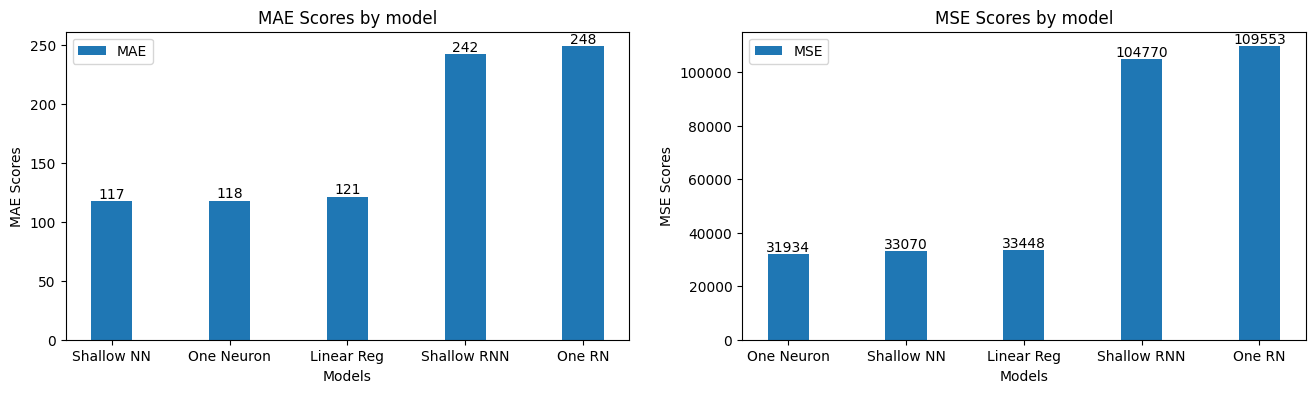

In [58]:
# Get the Elastic Net metrics
EN_data = pd.read_csv("model_output/elastic_net_results.csv")
LR_mae = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MAE'].values[0]
LR_mse = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MSE'].values[0]

models = ['Linear Reg', 'One Neuron', 'Shallow NN', 'One RN', 'Shallow RNN']
mae = [LR_mae, OneNeuron_val_mae, SDNN_val_mae,  OneRNN_val_mae, shallow_rnn_val_mae]
mse = [LR_mse, OneNeuron_val_mse, SDNN_val_mse, OneRNN_val_mse, shallow_rnn_val_mse]

# Sort by MAE
sorted_indices_mae = np.argsort(mae)
sorted_models_mae = [models[i] for i in sorted_indices_mae]
sorted_mae = [mae[i] for i in sorted_indices_mae]

# Sort by MSE
sorted_indices_mse = np.argsort(mse)
sorted_models_mse = [models[i] for i in sorted_indices_mse]
sorted_mse = [mse[i] for i in sorted_indices_mse]

x = np.arange(len(models))
bar_width = 0.35

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# MAE
bars_mae = axes[0].bar(x, sorted_mae, bar_width, label='MAE')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MAE Scores')
axes[0].set_title('MAE Scores by model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sorted_models_mae)
axes[0].legend()

# Add values above MAE bars
for bar, value in zip(bars_mae, sorted_mae):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.0f}', ha='center', va='bottom')

# MSE
bar_mse = axes[1].bar(x, sorted_mse, bar_width, label='MSE')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE Scores')
axes[1].set_title('MSE Scores by model')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sorted_models_mse)
axes[1].legend()

# Add values above MSE bars
for bar, value in zip(bar_mse, sorted_mse):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.0f}', ha='center', va='bottom')

plt.tight_layout
plt.show()

# SUMMARY & CONCLUSION

Both single neuron and shallow dense neural networks were able to at least match, if not slightly improve upon, the prediction accuracy of mutlilple linear regression applied to ontime flights. Three different keras tuners were used to search hypermodels for optimum hyperparameters, including the number of hidden layers, number of neurons per layer, learning rate, dropout rate, regularization rate, and optimizer algorithm. The Hyperband tuner consistently found the best hyperparameters, but required the longest search time. The most influential hyperparameters proved to be the learning rate, regularization rates, and dropout rates. Eventually, I dropped the number of layers and optimizer type from the hyperparameter search in favor of a single hidden layer and the Adam optimimzer, as they generally showed the best results. One implication is that complex interactions that would be revealed by complex architectures are unlikely to figure prominently in this dataset.

The TensorBoard module proved to be an effective tool for evaluating a model fit, easily displaying loss and metric plots that show if the model is over or under trained and if high bias or high variance exist. Plots for the bias and weights within each layer of a network help reveal the stability of the training process

One major flaw in this analysis is the data splitting used for the RNN models. The data should have been split sequentially with training data comning before validation data conming before test data. Instead the data were shuffled before splitting, meaning that the each dataset contains non-sequential data, which is fine for linear regression and the dense neural networks, problematic for the RNN time series analysis. Additionally, I failed to take the additional steps to Window the data and create tensors for the inputs and labels of each window. Having discovered these mistakes near the submission deadline, I decided to write my summary and conclusion before attempting to fix the errors.  Now that I've produced a summary of the work to date, I will begin a new notebook, 5.DFW_daily_flights_LSTM that follows methods used in the [TensorFlow timeseries tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series). I won't have time to write a separate summary and conclusion for this additional code, so please consider this to "supplmental" material.

# INTRODUCTION

## Libraries

In [78]:
import os
import datetime
import IPython

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Import data & column groups

In [2]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# Drop lag columns and date from data
df = df.drop(columns=lag_cols + ['date'])

print("Unique data types in df", df.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in df
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()
num_features = df.shape[1]

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")
print(f"\nAll columns accounted for: {len(categorical_cols) + len(numeric_cols) == num_features}")

Unique data types in df
float64    40
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64

Categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
Numeric columns: ['ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed

## Split data sequentially 70/20/10

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# print data shapes
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (1179, 64)
Validation data shape: (337, 64)
Test data shape: (169, 64)


## Preprocess data for recurrent neural network (RNN)

In [4]:
# Fit transformers to the training data
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(train_df[categorical_cols])
ohe_column_names = ohe.get_feature_names_out(input_features=categorical_cols)

# Define preprocessor
def preprocess(data):
    scaled_features = scaler.transform(data[numeric_cols])
    encoded_features = ohe.transform(data[categorical_cols])
    processed_data = pd.DataFrame(np.concatenate([scaled_features, encoded_features], axis=1),
                                  columns = numeric_cols + list(ohe_column_names))
    return processed_data

# Preprocess the data
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

print(f"\nNumber of columns before preprocessing: {num_features}")
print(f"Number of features after preprocessing: {train_df.shape[1]}")


Number of columns before preprocessing: 64
Number of features after preprocessing: 105


## WindowGenerator
The `WindowGenerator` class stores the raw data, that has already been split into train, validate, and test sets, and it handles indexes and offsets for windowing. Several methods are added to this class after it's initial creation. When the `split_window` method is added, the class will split data windows into separate tensors for features and labels. The `plot` method, produces a plot of an example batch showing inputs, labels, and predictions. The `make_dataset` method creates TensorFlow timeseries datastes that are batched, windowed, and ready for use in modeling.

In [5]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
               
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Instantiate WindowGenerators

In [6]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['flights_ontime'])

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                        label_columns=['flights_ontime'])

## Add split_window method

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# Add the method to the class
WindowGenerator.split_window = split_window

Demonstrate split_window on an example batch of 3 windows

In [8]:
# Stack three slices, the length of the total window. This creates an example batch of 3 windows, each of 7-timesteps and 105 features
example_batch = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_batch)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_batch.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 105)
Inputs shape: (3, 6, 105)
Labels shape: (3, 1, 1)


Create an "example" attribute for w2 and add the example batch inputs and labels

In [9]:
w2.example = example_inputs, example_labels

## Add plot method

In [45]:
def plot(self, model=None, plot_col='flights_ontime', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    # Plot inputs
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    # Plot labels
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    # Plot predictions
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

# Add the method to the class
WindowGenerator.plot = plot

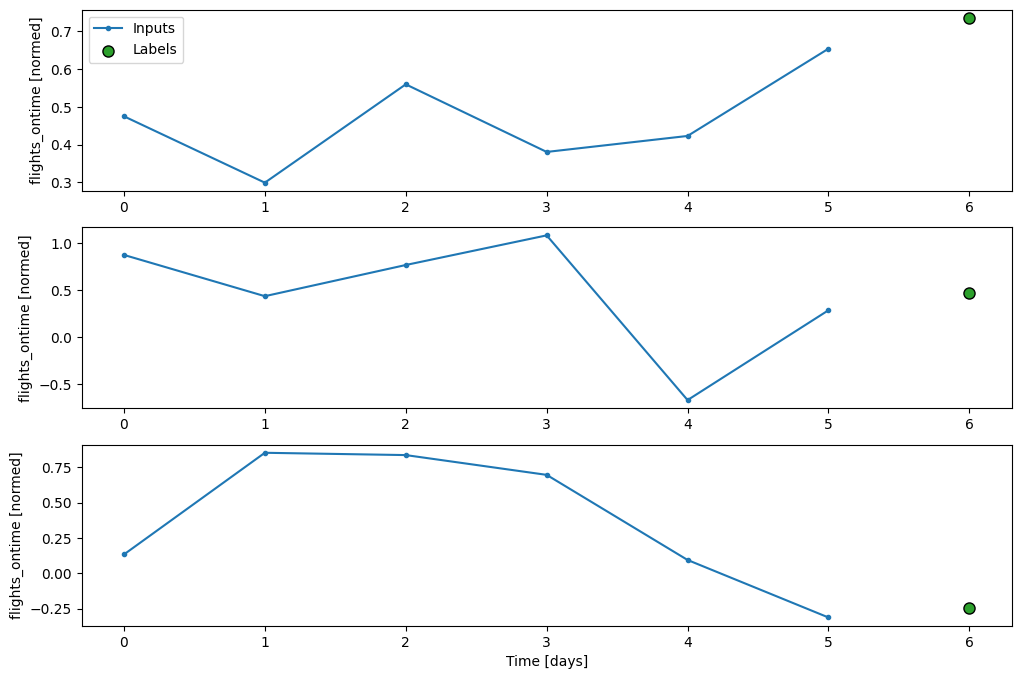

In [46]:
w2.plot()

## Add make_dataset

The make_dataset method creates TensorFlow timeseries datasets from the data objects held by WindowGenerator. The split_window function is mapped over the windows of the TensorFlow datasets, creating inputs and labels for each window. 

In [47]:
def make_dataset(self,data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

# Add the method to the class
WindowGenerator.make_dataset = make_dataset

# Add properties to datasets within WindowGenerator
Add properties for accessing the train, validation, and test datasets as TensorFlow timeseries datasets created by make_dataset. The `@property` decorator is used to define getter methods for properties of a class, allowing access to the result of a method as an attribute of the class. 

In [48]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# Add the properties to the class (redundant becuase the train, val, test, and example properties are already defined in the class)
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The `element_spec` attribute 

Inspect an element of a tf.data.Dataset of w2 using the element_spec attribute

In [49]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 105), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

 Iterating over a tf timeseries dataset produced and held within a WindowGenerator instance, e.g. `w2.train` produces batches of data, where each batch has an input tensor and a labels tensor.

In [51]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time steps, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time steps, features): {example_labels.shape}')

Inputs shape (batch, time steps, features): (32, 6, 105)
Labels shape (batch, time steps, features): (32, 1, 1)


## single_step_window

In [52]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['flights_ontime'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['flights_ontime']

Like for w2.train, iterating over single_step_window.train produces batches of two Tensors, inputs and labels. w2 used 6 steps in the input and single_step_window uses 1.

In [53]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 105)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
The `Baseline` class inherits from `keras.Model` and uses the current value of a label to predict a label one step (one day) into the future, ignoring all other information. We hope to beat this model with a LSTM recurrent network that considers current and recent values of the label and other features.

In [18]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

The baseline model of using the previous day's ontime flights to predict the next day's ontime flights produced MSE and MAE validation set scores of 2.51 and 1.36 respectively. Again, we'll try to beat this with a LSTM recurrent network.

In [54]:
baseline = Baseline(label_index=column_indices['flights_ontime'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=0)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

print("Validation performance: ", val_performance)
print("Test performance: ", performance)


Validation performance:  {'Baseline': [2.5069453716278076, 1.3683136701583862]}
Test performance:  {'Baseline': [2.7119243144989014, 1.335585117340088]}


Below we create a wider window of 28 days (4 weeks) for visually evalating the baseline model. 

In [55]:
wide_window = WindowGenerator(
    input_width=28, label_width=28, shift=1,
    label_columns=['flights_ontime'])

wide_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Label column name(s): ['flights_ontime']

In [56]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 28, 105)
Output shape: (32, 28, 1)


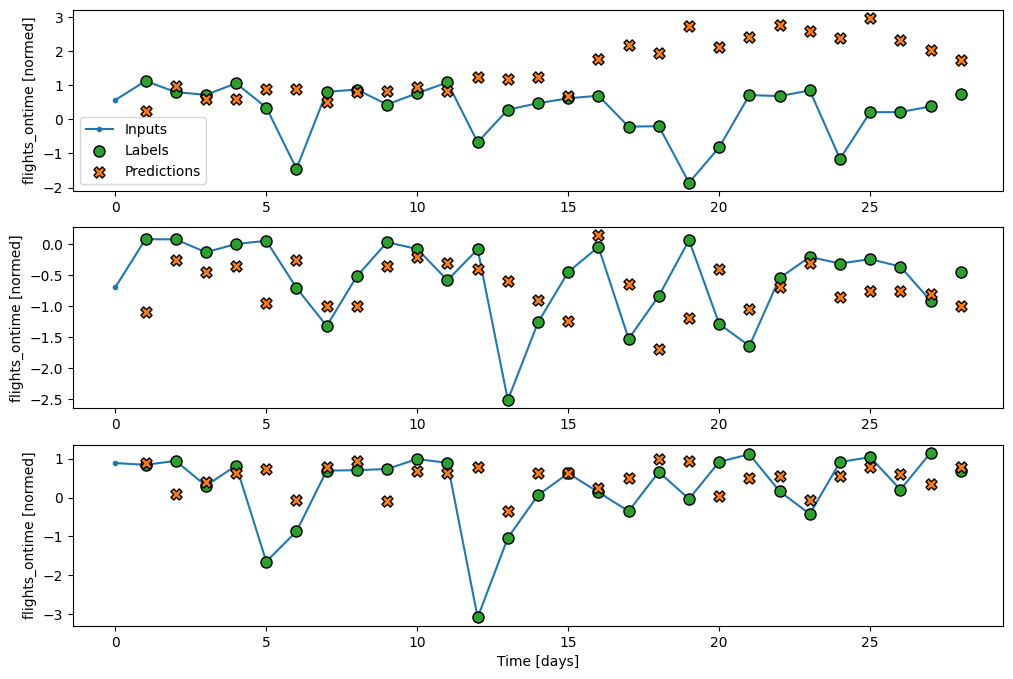

In [57]:
wide_window.plot(baseline)

In [21]:
wide_window.example[0]

<tf.Tensor: shape=(32, 28, 105), dtype=float32, numpy=
array([[[-0.99603975, -0.654722  ,  1.2736163 , ...,  0.        ,
          1.        ,  0.        ],
        [-0.9931016 , -0.654722  ,  1.3867904 , ...,  0.        ,
          1.        ,  0.        ],
        [-0.9901634 , -0.654722  ,  1.4999645 , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [-0.9225855 , -0.654722  ,  0.5945719 , ...,  0.        ,
          1.        ,  0.        ],
        [-0.91964734, -0.654722  ,  0.70774597, ...,  0.        ,
          1.        ,  0.        ],
        [-0.9167091 , -0.654722  ,  0.82092   , ...,  0.        ,
          1.        ,  0.        ]],

       [[ 0.82856405,  0.35168898, -0.9898652 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.8315022 ,  0.35168898, -0.8766911 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.8344404 ,  0.35168898, -0.763517  , ...,  0.        ,
          1.        ,  0.        ],
        ...,

In [60]:
linear = Sequential([Dense(units=1)])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 105)
Output shape: (32, 1, 1)


In [70]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss='mean_squared_error',
                optimizer=Adam(),
                metrics=['mean_absolute_error'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [71]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
37/37 [==============================] - 0s 3ms/step - loss: 0.4619 - mean_absolute_error: 0.4787 - val_loss: 0.3916 - val_mean_absolute_error: 0.4188
Epoch 2/20
37/37 [==============================] - 0s 2ms/step - loss: 0.4526 - mean_absolute_error: 0.4757 - val_loss: 0.3765 - val_mean_absolute_error: 0.4100
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 0.4481 - mean_absolute_error: 0.4727 - val_loss: 0.3717 - val_mean_absolute_error: 0.4082
Epoch 4/20
37/37 [==============================] - 0s 2ms/step - loss: 0.4436 - mean_absolute_error: 0.4668 - val_loss: 0.3709 - val_mean_absolute_error: 0.4067
Epoch 5/20
37/37 [==============================] - 0s 2ms/step - loss: 0.4402 - mean_absolute_error: 0.4683 - val_loss: 0.3706 - val_mean_absolute_error: 0.4069
Epoch 6/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4389 - mean_absolute_error: 0.4617 - val_loss: 0.3729 - val_mean_absolute_error: 0.4072
Epoch 7/20
11/11 [==========

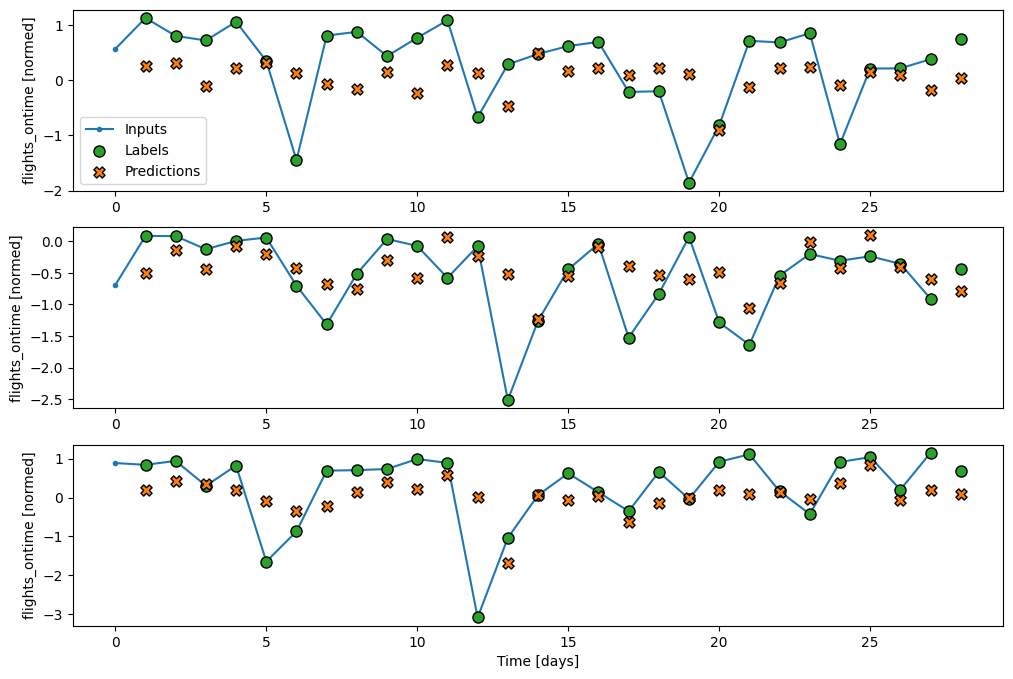

In [72]:
wide_window.plot(linear)

In [74]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [76]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 28, 105)
Output shape: (32, 28, 1)


In [79]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.7129 - mean_absolute_error: 0.6277


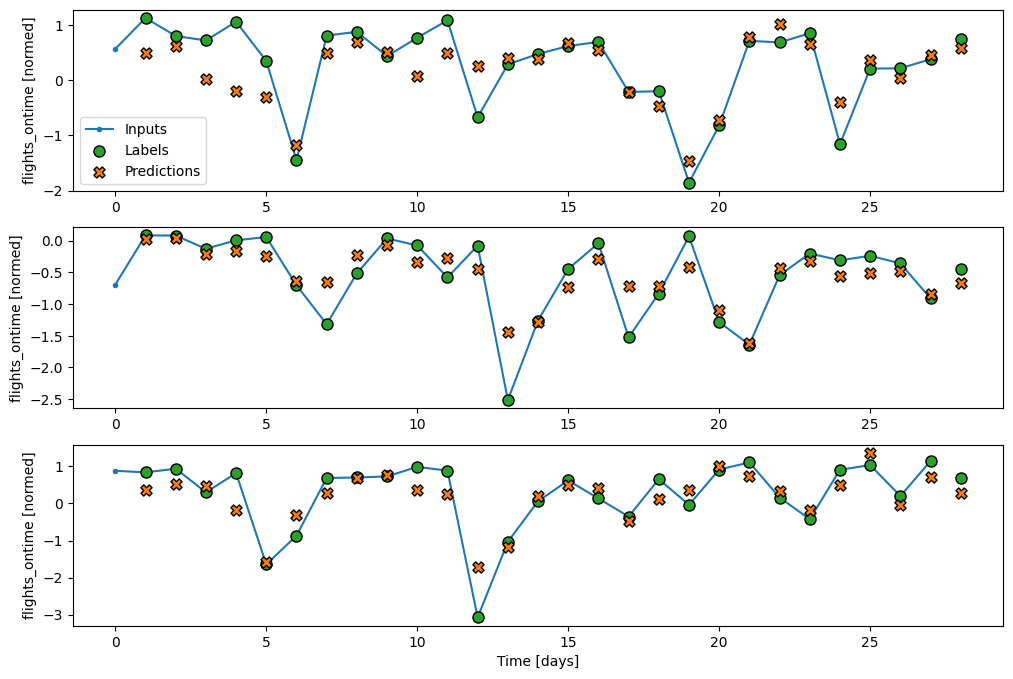

In [80]:
wide_window.plot(lstm_model)